In [2]:
contributor = "Nada"

## EDA

### Step 1: Import Libraries

In [3]:
import pandas as pd
import json
import numpy as np
import csv
from datetime import datetime
import os
import glob
# from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.ensemble import RandomForestRegressor
import plotly.graph_objects as go
# from pandarallel import pandarallel
import matplotlib.pyplot as plt
# pandarallel.initialize(progress_bar=True)
# import pytz
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans
import numpy as np
from shapely.geometry import MultiPoint
from shapely.ops import unary_union

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Step 2: Load Data

In [4]:
# Directory and file name pattern
directory = 'Cleaning/trial_week/clean_data'
file_base = 'clean_2024-01-'


# Generate the list of file names
files_names = [f'{file_base}{i}.json' for i in range(28, 29)] # 28 only

# Generate the list of file directories
files = [os.path.join(directory, file_name) for file_name in files_names]

data = []

In [5]:
# Load data from each JSON file
for file_name in files:
    with open(file_name, 'r') as file:
        for line in file:
            data.append(json.loads(line))

# Create a DataFrame
df = pd.DataFrame(data)

# Step 1: Drop the 'time_diff' attribute if it exists
if 'time_diff' in df.columns:
    df.drop('time_diff', axis=1, inplace=True)

# # Step 2: Redefine the features after dropping 'time_diff'
# X = df_features.drop(columns=['time_diff'], errors='ignore')

# Calculate trip time in seconds
df['trip_time'] = df['time']

# Now, drop the 'time' column
df.drop(columns=['time'], inplace=True)

# Drop rows with missing values (if any)
df.dropna(inplace=True)

In [6]:
# Load pooling data
pooling_file_path = 'Cleaning/anon_pooling_jan_24_amman.csv' 
df_pooling = pd.read_csv(pooling_file_path)

#### Load Merchants' data

In [7]:
# df.columns
df_pooling.columns

Index(['order_id', 'order_type', 'pick_up_zone', 'drop_off_zone',
       'order_received_timestamp', 'order_status', 'cancellation_type',
       'initial_eta', 'upfront_eta', 'acceptance_time', 'delay_dispatch_time',
       'captain_assignment_time', 'wait_time_at_merchant',
       'food_preparation_time', 'time_to_customer', 'wait_time_in_journey',
       'wait_time_at_customer', 'captain_engagement_time', 'delivery_time',
       'cancellation_time', 'pickup_longitude', 'pickup_latitude',
       'distance_travelled_km', 'captain_id', 'booking_id', 'route_id', 'day',
       'is_pooled'],
      dtype='object')

In [8]:
os.getcwd()

'/home/g1/eta-rfr'

In [9]:
# Load merachant data
merch_file_path = 'merchants_csv/order_merchant_id_anon.csv' 
merchants_df = pd.read_csv(merch_file_path)

In [10]:
# merchants_df = load_data('merchants_csv')
merchants_df.head()

order_id  \
0  15ba48883ab59910c0aa7aefb096c01301c24661384eb9...   
1  b85d95db3ddfe71f2b3f04d24960e829c2478b65838fda...   
2  8e49225f81445237d0633ef2b7a55d40d82d3f714ee1cc...   
3  5f784bcf4f7da01aeac305ae67271e984c6990084a18a0...   
4  a3b80e573412e7d031e8fceae7f50a02bd588f65e1cfef...   

                                         merchant_id         day  \
0  85a33ce1e81c75b635e7fc4536d3739103e0d680e32858...  2024-01-02   
1  471c413808bcb33f2afad2a7837658647c827b887b9715...  2024-01-05   
2  401173ac8f8081d1099b002a10b45314e344acd0e3b3eb...  2024-01-05   
3  f812095cfd0e0cb04befd8a0a77e9bc1fa94d0becbffeb...  2024-01-05   
4  e15943ef8e9ec433429f8e237b835a07175a50f2d5b5e9...  2024-01-05   

   merchant_lat  merchant_lng  
0        31.957        35.856  
1        31.950        35.883  
2        31.992        35.936  
3        31.955        35.855  
4        31.997        35.846

In [11]:
merchants_df.columns

Index(['order_id', 'merchant_id', 'day', 'merchant_lat', 'merchant_lng'], dtype='object')

In [12]:
df.columns

Index(['trip_id', 'time_gap', 'dist', 'lats', 'driverID', 'weekID', 'timeID',
       'dateID', 'lngs', 'dist_gap', 'trip_time'],
      dtype='object')

#### Left join merchants on the pings df

In [13]:
# First merge merchants_df with df_pooling on 'order_id'
merged_pooling = df_pooling.merge(merchants_df[['order_id', 'merchant_id']], on='order_id', how='left')

# Now merge the resulting DataFrame with df on 'trip_id' (matching booking_id in df_pooling)
df = df.merge(merged_pooling[['booking_id', 'merchant_id']], left_on='trip_id', right_on='booking_id', how='left')

df = df.drop(columns=['booking_id'])

# Check how many 'merchant_id' values are null after the merge
null_merchant_count = df['merchant_id'].isnull().sum()

# Output the count of null 'merchant_id'
print(null_merchant_count)


0


In [14]:
df.columns

Index(['trip_id', 'time_gap', 'dist', 'lats', 'driverID', 'weekID', 'timeID',
       'dateID', 'lngs', 'dist_gap', 'trip_time', 'merchant_id'],
      dtype='object')

In [15]:
df.head()

trip_id  \
0  000c3d26955e90c6218695a72ae4c3255580319a1cb8ac...   
1  000e874d4760fe8abee13dafdfbaf304ad4964a7f2f2e7...   
2  0021d1f91196cd35ab1d51dd50e56e42e263c51b489307...   
3  00248a3aded3125bb48c280f9d32e88f53c8d0bdef213a...   
4  00460b78326793989b5861abfa43270413873c540c818c...   

                                            time_gap       dist  \
0  [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...   8.444665   
1  [0.0, 5.0, 10.0, 19.0, 30.0, 55.0, 60.0, 65.0,...  10.503006   
2  [0.0, 46.0, 56.0, 61.0, 71.0, 82.0, 92.0, 102....   7.245916   
3  [0.0, 5.0, 20.0, 29.0, 38.0, 48.0, 58.0, 67.0,...   3.096324   
4  [0.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0...   7.353065   

                                                lats  \
0  [31.954, 31.954, 31.954, 31.954, 31.954, 31.95...   
1  [31.977, 31.977, 31.977, 31.977, 31.977, 31.97...   
2  [32.029, 32.029, 32.029, 32.029, 32.029, 32.02...   
3  [32.025, 32.025, 32.025, 32.025, 32.025, 32.02...   
4  [31.948, 31.95, 31.95, 31.951, 31.951, 31.951,...   

                                            driverID  weekID  timeID  dateID  \
0  17ccda7c4c72184de4734b8d75ced8a1baf9d382caa359...       6     797      27   
1  93e284547b2612b1883409f6faab36c82b6d2305ba3dc0...       6     657      27   
2  397ad377afcb1d9a2cb4af91a3be307fb84e6fca485df6...       6    1205      27   
3  7fab4337bd7a12738059be709d4b2a4ddf60a72f2746f9...       6     855      27   
4  cdfd836c5676af3b9885ecea6a373fdd592b4457c72197...       6    1273      27   

                                                lngs  \
0  [35.875, 35.875, 35.875, 35.875, 35.874, 35.87...   
1  [35.937, 35.937, 35.937, 35.937, 35.937, 35.93...   
2  [35.863, 35.864, 35.864, 35.864, 35.864, 35.86...   
3  [35.876, 35.876, 35.876, 35.876, 35.876, 35.87...   
4  [35.851, 35.851, 35.851, 35.851, 35.851, 35.85...   

                                            dist_gap  trip_time  \
0  [0, 0.0, 0.0, 0.0, 0.09454028774134127, 0.0945...     1635.0   
1  [0, 0.0, 0.0, 0.0, 0.0, 0.09451672240430886, 0...     2718.0   
2  [0, 0.09446338806903404, 0.09446338806903404, ...     2499.0   
3  [0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....      891.0   
4  [0, 0.22177183462403766, 0.22177183462403766, ...     1741.0   

                                         merchant_id  
0  efbe459cd077a45452fb99ce43e8b477d7adc84fe4bf88...  
1  6e2e4729bcdcb93a8784cb782774c6efd8ac14c0612f99...  
2  eb747f0e589f3da2a3b840e980c54d13000984e95f5857...  
3  bb3d72db7d47d1669602b3535c5c9143095a155288952d...  
4  b793061b3acd7108693f1126fff4bd4a9b241aec1d5fe8...

In [16]:
# Group by 'merchant_id' and count the number of rows in each group
merchant_group_counts = df.groupby('merchant_id').size().reset_index(name='count')

# Filter the groups where the count is greater than 1
filtered_merchant_groups = merchant_group_counts[merchant_group_counts['count'] > 1]

max_count = filtered_merchant_groups['count'].max()


# Display the filtered result
print(filtered_merchant_groups)

# Display the maximum count     
print("\nLargest group count:", max_count)


                                            merchant_id  count
1     002225f0f3a28cbc13591d70a1ec6ac3f254ff0ecd9c9c...      4
2     004af377dd4cce3fd9d97a296892c55e79bed133ddb62f...      7
4     0083c5defc22769e7e35a5966fbef22324050f611eb0f5...      5
6     01427158703e37aafe4301e3e5d0fe6da6949ec9b2c43d...      6
7     018b1c53771301bc7237c0aaf32ca81b731d585526f021...      3
...                                                 ...    ...
1047  fddce900b47e50ea82db6ac5a2cb6dc772e7e36ee9ca99...     12
1048  fe055f377a4d6c7ab43f795850dccc994a4bda571190f6...      4
1050  fe4dfff1f20aa9ce43bfc6260abb99ee8d8c5bcb0f78de...      4
1052  feac08e0f462092a8f6fb9019f20150d5e3a507aa0d99f...     37
1056  ffc06b495b2be53497f7673db10fbf006fc05ca3ea869b...      6

[683 rows x 2 columns]

Largest group count: 78


### Step 3: Split Trips into three segments: Driver-to-Merchant, Merchant-to-Customer, and Wait Time at Merchant

#### Delete: Wait times comparison

In [17]:
# Function to find the first two consecutive occurrences and the last two consecutive occurrences of pickup coordinates
def find_consecutive_occurrences(lats, lngs, pickup_lat, pickup_lng):
    first_index = None
    last_index = None
    
    # Loop to find the first two consecutive occurrences
    for i in range(1, len(lats)):
        if (lats[i] == pickup_lat and lngs[i] == pickup_lng) and (lats[i-1] == pickup_lat and lngs[i-1] == pickup_lng):
            first_index = i - 1  # First occurrence of the two consecutive matches
            break
    
    # Loop to find the last two consecutive occurrences
    for i in range(len(lats) - 1, 0, -1):
        if (lats[i] == pickup_lat and lngs[i] == pickup_lng) and (lats[i-1] == pickup_lat and lngs[i-1] == pickup_lng):
            last_index = i  # Last occurrence of the two consecutive matches (we want the last of these two)
            break

    return first_index, last_index

# Prepare a list to store results
results = []

# Iterate over each trip in the JSON data
for index, row in df.iterrows():
    trip_id = row['trip_id']
    lats = row['lats']
    lngs = row['lngs']
    time_gap = row['time_gap']
    
    # Find matching entry in the anon_pooling CSV based on trip_id and booking_id
    match = df_pooling[df_pooling['booking_id'] == trip_id]
    
    if not match.empty:
        # Extract pickup coordinates from the pooling data
        pickup_lat = match['pickup_latitude'].iloc[0]
        pickup_lng = match['pickup_longitude'].iloc[0]
        
        # Find the first two consecutive occurrences and the last two consecutive occurrences
        first_index, last_index = find_consecutive_occurrences(lats, lngs, pickup_lat, pickup_lng)
        
        if first_index is not None and last_index is not None:
            # Get the timegap of the first occurrence of the first two consecutive coordinates
            first_time_gap = time_gap[first_index]
            # Get the timegap of the last occurrence of the last two consecutive coordinates
            last_time_gap = time_gap[last_index]
            
            # Calculate the time difference (first occurrence - last occurrence)
            time_difference = last_time_gap- first_time_gap
            
            # Extract the wait_time_at_merchant from the matching row in the anon_pooling CSV
            wait_time_at_merchant = match['wait_time_at_merchant'].iloc[0]
            
            # Calculate the difference between the time difference and wait_time_at_merchant
            difference = time_difference - (wait_time_at_merchant*60)
            
            # Append the result to the list
            results.append({
                'trip_id': trip_id,
                'first_time_gap': first_time_gap,
                'last_time_gap': last_time_gap,
                'time_difference': time_difference,
                'wait_time_at_merchant': round(wait_time_at_merchant*60,2),
                'difference': difference
            })
        else:
            # If no consecutive coordinates are found, append a message to the results
            results.append({
                'trip_id': trip_id,
                'error': 'No consecutive coordinates found'
            })

# Convert results to a DataFrame and save as CSV
output_df = pd.DataFrame(results)
output_csv_file = 'comparison_results.csv'
output_df.to_csv(output_csv_file, index=False)

print(f"Results saved to {output_csv_file}")


Results saved to comparison_results.csv


#### Delete: Find real coordinates and their indices
This is based on the time to customer and wait time at customer attributes

In [18]:
# csv_file_path = 'Cleaning/careems data/anon_pooling_jan_24_amman.csv'  # Replace with the actual CSV file path
# df_pooling = pd.read_csv(csv_file_path)

# Convert to seconds
def convert_to_seconds(time_string):
    if pd.isna(time_string):
        return 0  
    try:
        return float(time_string) * 60  
    except ValueError:
        return 0  

def track_movement(lats, lngs, start_index, tolerance=0.00, smoothing_window=3):
    # Check for stationary coordinates before the start_index with smoothing
    driver_to_merch_index = start_index  # Set default to the given start_index

    start_lat = lats[start_index]
    start_lng = lngs[start_index]
    
    # Backward smoothing: search backwards to find any earlier stationary coordinates
    deviation_count = 0
    for i in range(start_index - 1, -1, -1):
        if abs(lats[i] - start_lat) > tolerance or abs(lngs[i] - start_lng) > tolerance:
            deviation_count += 1
            if deviation_count >= smoothing_window:
                break  # Stop the backward search if movement persists beyond smoothing window
        else:
            deviation_count = 0  # Reset the deviation count if the point goes back to stationary
            driver_to_merch_index = i  # Update index to earliest stationary point
    
    # Forward smoothing: check for movement starting from the new driver_to_merch_index
    deviation_count = 0
    for i in range(driver_to_merch_index, len(lats)):
        if abs(lats[i] - start_lat) > tolerance or abs(lngs[i] - start_lng) > tolerance:
            deviation_count += 1
            if deviation_count >= smoothing_window:
                return driver_to_merch_index, i - deviation_count + 1  # Return start index and last stationary point
        else:
            deviation_count = 0  # Reset the deviation count if the point goes back to stationary

    return driver_to_merch_index, None  # No movement detected beyond tolerance

# Prepare a list to store results
results = []

# Iterate over each trip in the JSON data
for index, row in df.iterrows():
    trip_id = row['trip_id']
    lats = row['lats']
    lngs = row['lngs']
    time_gap = row['time_gap']
    
    # Find matching entry in the anon_pooling CSV based on trip_id and booking_id
    match = df_pooling[df_pooling['booking_id'] == trip_id]
    
    if not match.empty:
        # Get the last time_gap
        last_time_gap = time_gap[-1]
        
        # Convert wait_time_at_merchant, time_to_customer, wait_time_at_customer to seconds
        wait_time_at_merchant = convert_to_seconds(match['wait_time_at_merchant'].iloc[0])
        time_to_customer = convert_to_seconds(match['time_to_customer'].iloc[0])
        wait_time_at_customer = convert_to_seconds(match['wait_time_at_customer'].iloc[0])
        
        # Calculate the total wait time in seconds
        merchant_to_cust_time = wait_time_at_merchant + time_to_customer + wait_time_at_customer
        
        # Find the time_gap where total_wait_time is subtracted from the last time_gap
        target_time_gap = last_time_gap - merchant_to_cust_time 
        
        # Find the corresponding index for the target_time_gap
        closest_time_gap_index = min(range(len(time_gap)), key=lambda i: abs(time_gap[i] - target_time_gap))
        
        # Track the movement starting from the closest time_gap index
        driver_to_merch_index, last_stationary_index = track_movement(lats, lngs, closest_time_gap_index)
        
        if last_stationary_index is not None:
            # Get the time_gap where movement starts
            movement_time_gap = time_gap[last_stationary_index]
            
            # Append the result to the list
            results.append({
                'trip_id': trip_id,
                'last_time_gap': last_time_gap,
                'arrived_at_merch_time_gap': round(target_time_gap,2),
                'last_stationary_time_gap': movement_time_gap,
                'last_stationary_index': last_stationary_index,
                'driver_to_merch_index': driver_to_merch_index
            })

# Convert results to a DataFrame and save as CSV
output_df = pd.DataFrame(results)
output_csv_file = 'movement_time_gaps.csv'
output_df.to_csv(output_csv_file, index=False)

print(f"Results saved to {output_csv_file}")


Results saved to movement_time_gaps.csv


Extract Pickup coordinates from the list of pings

In [19]:
# Prepare a list to store split trips
pickup_info = []

# Iterate over each trip and split based on the given conditions
for index, row in df.iterrows():
    trip_id = row['trip_id']
    lats = row['lats']
    lngs = row['lngs']
    
    # Find the corresponding target_time_gap and last_stationary_index from previous results
    result = next((r for r in results if r['trip_id'] == trip_id), None)
    
    if result:
        last_stationary_index = result['last_stationary_index']

        pickup_info.append({
            'trip_id': trip_id,
            'pickup_lat': lats[last_stationary_index],
            'pickup_lng': lngs[last_stationary_index]
        })
     

pickup_df = pd.DataFrame(pickup_info)
output_csv_file = 'pickup_info.csv'
pickup_df.to_csv(output_csv_file, index=False)

print(f"Results saved to {output_csv_file}")      

Results saved to pickup_info.csv


#### Stationarity Detection

##### Miscellaneous

In [20]:
os.getcwd()

'/home/g1/eta-rfr'

In [21]:
os.chdir('Splitting')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5839 entries, 0 to 5838
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   trip_id      5839 non-null   object 
 1   time_gap     5839 non-null   object 
 2   dist         5839 non-null   float64
 3   lats         5839 non-null   object 
 4   driverID     5839 non-null   object 
 5   weekID       5839 non-null   int64  
 6   timeID       5839 non-null   int64  
 7   dateID       5839 non-null   int64  
 8   lngs         5839 non-null   object 
 9   dist_gap     5839 non-null   object 
 10  trip_time    5839 non-null   float64
 11  merchant_id  5839 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 547.5+ KB


##### Stationarity Detection for all trips

In [23]:
def detect_stationary_intervals(df, output_path='stationary_intervals_all_trips.csv'):
    results = []
    for index, row in df.iterrows():
        trip_id = row['trip_id']
        lats = np.array(row['lats'])
        lngs = np.array(row['lngs'])
        time_gap = np.array(row['time_gap'])
        
        # Compute differences between consecutive points directly from lat/lng arrays
        lat_diff = np.abs(np.diff(lats))
        lng_diff = np.abs(np.diff(lngs))
        print(len(time_gap))
        # Identify stationary intervals (where there is no change in both lat and lng)
        stationary_indices = np.where((lat_diff == 0) & (lng_diff == 0))[0]
        print(stationary_indices)
        break
    return results

stationary_df = detect_stationary_intervals(df)

246
[  0   1   2   4   5   8  10  12  13  15  19  20  21  22  24  26  27  28
  29  30  31  32  33  34  36  38  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  72  73  74  75  76  77  79  80  81  82  84  86  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 108 114 118 120 123
 126 128 130 131 133 138 140 142 146 149 151 152 154 157 161 164 166 167
 171 173 174 175 176 178 179 180 181 182 184 185 187 188 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 230
 232 234 236 238 241 244]


In [29]:
def detect_stationary_intervals(df, output_path='stationary_intervals_all_trips_truncated.csv'):
    results = []
    for index, row in df.iterrows():
        trip_id = row['trip_id']
        lats = np.array(row['lats'])
        lngs = np.array(row['lngs'])
        time_gap = np.array(row['time_gap'])
        
        # Compute differences between consecutive points directly from lat/lng arrays
        lat_diff = np.abs(np.diff(lats))
        lng_diff = np.abs(np.diff(lngs))

        # Identify stationary intervals (where there is no change in both lat and lng)
        stationary_indices = np.where((lat_diff == 0) & (lng_diff == 0))[0]
        
        # Group consecutive stationary indices into intervals
        if len(stationary_indices) > 0:
            start_idx = stationary_indices[0]
            for i in range(1, len(stationary_indices)):
                # If the current index is not consecutive, close the interval
                if stationary_indices[i] != stationary_indices[i - 1] + 1:
                    end_idx = stationary_indices[i - 1]
                    # Save the interval only if it has more than one index
                    if end_idx > start_idx:
                        interval = {
                            "trip_id": trip_id,
                            "start_idx": int(start_idx),
                            "end_idx": int(end_idx)+1,
                            "start_lat": float(lats[start_idx]),
                            "start_lng": float(lngs[start_idx]),
                            "end_lat": float(lats[end_idx+1]),
                            "end_lng": float(lngs[end_idx+1]),
                            "time_elapsed": float(time_gap[end_idx+1] - time_gap[start_idx])
                        }
                        results.append(interval)
                    # Start a new interval
                    start_idx = stationary_indices[i]
            # Add the last interval if it has more than one index
            end_idx = stationary_indices[-1]
            if end_idx > start_idx:
                interval = {
                    "trip_id": trip_id,
                    "start_idx": int(start_idx),
                    "end_idx": int(end_idx)+1,
                    "start_lat": float(lats[start_idx]),
                    "start_lng": float(lngs[start_idx]),
                    "end_lat": float(lats[end_idx+1]),
                    "end_lng": float(lngs[end_idx+1]),
                    "time_elapsed": float(time_gap[end_idx+1] - time_gap[start_idx])
                }
                results.append(interval)

    # Convert results to a DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_path, index=False)

    print(f"Stationary intervals saved to {output_path}")
    return results_df

stationary_df = detect_stationary_intervals(truncated_df)

Stationary intervals saved to stationary_intervals_all_trips_truncated.csv


In [28]:
def truncate_trips_if_stationary(df, stationary_df):
    truncated_trips = []

    # Iterate over each trip in the df
    for index, row in df.iterrows():
        trip_id = row['trip_id']
        lats = row['lats']
        lngs = row['lngs']
        time_gap = row['time_gap']

        # Get the last coordinates of the trip
        last_lat, last_lng = lats[-1], lngs[-1]

        # Find the corresponding stationary intervals for this trip
        intervals = stationary_df[stationary_df['trip_id'] == trip_id]

        if not intervals.empty:
            # Get the last stationary interval for this trip
            last_interval = intervals.iloc[-1]

            # Get the coordinates and time elapsed for the last stationary interval
            interval_lats = row['lats'][last_interval['start_idx']:last_interval['end_idx'] + 1]
            interval_lngs = row['lngs'][last_interval['start_idx']:last_interval['end_idx'] + 1]
            interval_time_gap = row['time_gap'][last_interval['start_idx']:last_interval['end_idx'] + 1]

            interval_lat, interval_lng = last_interval['end_lat'], last_interval['end_lng']
            time_elapsed = last_interval['time_elapsed']

            # Check if the last stationary interval's coordinates match the last trip coordinates
            if (last_lat == interval_lat and last_lng == interval_lng) and time_elapsed > 10:
                # print(f"Truncating trip_id: {trip_id}")

                # Keep only the first two entries of the stationary segment
                truncated_trip = {
                    'trip_id': trip_id,
                    'lats': lats[:last_interval['start_idx'] + 1],  # First two latitude entries of the stationary interval
                    'lngs': lngs[:last_interval['start_idx'] + 1],  # First two longitude entries of the stationary interval
                    'time_gap': time_gap[:last_interval['start_idx'] + 1],  # First two time gaps of the stationary interval
                    'driverID': row['driverID'],
                    'weekID': row['weekID'],
                    'timeID': row['timeID'],
                    'dateID': row['dateID'],
                    'merchant_id': row['merchant_id']
                }
                truncated_trips.append(truncated_trip)
            else:
                # If no truncation is needed, keep the original trip
                truncated_trips.append(row.to_dict())
        else:
            # If no stationary intervals exist, keep the original trip
            truncated_trips.append(row.to_dict())

    # Convert the list of truncated trips back into a DataFrame
    truncated_df = pd.DataFrame(truncated_trips)
    return truncated_df

# Example usage
truncated_df = truncate_trips_if_stationary(df, stationary_df)
truncated_df.to_csv('truncated_trips.csv', index=False)

# print("Truncated trips saved to 'truncated_trips.csv'")
truncated_df_json = truncated_df.to_dict(orient='records')

with open('truncated_trips.json', 'w') as file:
    for json_obj in truncated_df_json:
        json.dump(json_obj, file)
        file.write('\n')


Truncating trip_id: 000e874d4760fe8abee13dafdfbaf304ad4964a7f2f2e7ede42db516dec685d7
Truncating trip_id: 0021d1f91196cd35ab1d51dd50e56e42e263c51b4893076f22edacc1e8dc47b4
Truncating trip_id: 00248a3aded3125bb48c280f9d32e88f53c8d0bdef213a24447325e1708924a5
Truncating trip_id: 00460b78326793989b5861abfa43270413873c540c818c8d87da2fcc6bf18585
Truncating trip_id: 005bda3270ea904260295e1ceba7d4d88f86f3ce251dcaa2e48e8e710c12ab97
Truncating trip_id: 006568ecf27349bb6447d421b7995ed89a22e15de089eda4cb0d28233223697b
Truncating trip_id: 00a066677fc7a691f0a8d256ac8a94dabefe8d7b2031ae0f4c3395e2a4aebd5a
Truncating trip_id: 00a8a1894f7525143aa5ae66c46f635f23e4e7b33f524427f89d3a2060b050ea
Truncating trip_id: 00b199b347c7395fd4c6e137ec23e1f9c12bc2269c66da6bd2022ee413e696ea
Truncating trip_id: 00bc9f8459b615b1e36baa53c3c2ea567c64698ecf1af51676680fa59a8c5156
Truncating trip_id: 00c56a189d06ba9935e7f5faf23adf5e6f1ee7822ae83738f71a1c6675df8b97
Truncating trip_id: 00c7be86f7d167ae506402a77b0d7fecf1b65e3a06e94

In [30]:
def extract_longest_stationary_interval(stationary_df):
    # Find the longest stationary interval for each trip_id based on time_elapsed
    longest_intervals = stationary_df.loc[stationary_df.groupby('trip_id')['time_elapsed'].idxmax()]

    longest_intervals.reset_index(drop=True, inplace=True)
    
    return longest_intervals

# Example usage:
longest_intervals_df = extract_longest_stationary_interval(stationary_df)
longest_intervals_df.to_csv('longest_stationary_intervals_truncated.csv', index=False)


In [31]:
longest_intervals_df.columns

Index(['trip_id', 'start_idx', 'end_idx', 'start_lat', 'start_lng', 'end_lat',
       'end_lng', 'time_elapsed'],
      dtype='object')

##### Stationarity detection w smoothing

In [21]:
import numpy as np
import pandas as pd

def detect_stationary_intervals_with_tolerance(df, tolerance=0.001, output_path='smooth2_stationary_intervals_all_trips.csv'):
    results = []
    
    for index, row in df.iterrows():
        trip_id = row['trip_id']
        lats = np.array(row['lats'])
        lngs = np.array(row['lngs'])
        time_gap = np.array(row['time_gap'])
        
        # Initialize variables for tracking intervals
        in_stationary_period = False
        stationary_start_idx = None
        deviation_occurred = False
        
        for i in range(1, len(lats)):
            # Use np.isclose to check if the points are within the tolerance
            lat_is_close = np.isclose(lats[i], lats[i - 1], atol=tolerance)
            lng_is_close = np.isclose(lngs[i], lngs[i - 1], atol=tolerance)
            
            # Check if both latitude and longitude are close (stationary)
            if lat_is_close and lng_is_close:
                if not in_stationary_period:
                    # Start a new stationary period
                    stationary_start_idx = i - 1
                    in_stationary_period = True
                    deviation_occurred = False  # Reset deviation flag for this period
            else:
                # Not within tolerance, check for a single temporary deviation
                if in_stationary_period and not deviation_occurred:
                    deviation_occurred = True  # Allow one deviation
                elif in_stationary_period and deviation_occurred:
                    # Second deviation, end stationary period
                    stationary_end_idx = i - 1
                    if stationary_start_idx is not None and stationary_end_idx > stationary_start_idx:
                        interval = {
                            "trip_id": trip_id,
                            "start_idx": int(stationary_start_idx),
                            "end_idx": int(stationary_end_idx),
                            "start_lat": float(lats[stationary_start_idx]),
                            "start_lng": float(lngs[stationary_start_idx]),
                            "end_lat": float(lats[stationary_end_idx]),
                            "end_lng": float(lngs[stationary_end_idx]),
                            "time_elapsed": float(time_gap[stationary_end_idx] - time_gap[stationary_start_idx])
                        }
                        results.append(interval)
                    # Reset for next potential stationary period
                    in_stationary_period = False
                    stationary_start_idx = None
        
        # Handle case if the trip ends while still in a stationary period
        if in_stationary_period and stationary_start_idx is not None:
            stationary_end_idx = len(lats) - 1
            interval = {
                "trip_id": trip_id,
                "start_idx": int(stationary_start_idx),
                "end_idx": int(stationary_end_idx),
                "start_lat": float(lats[stationary_start_idx]),
                "start_lng": float(lngs[stationary_start_idx]),
                "end_lat": float(lats[stationary_end_idx]),
                "end_lng": float(lngs[stationary_end_idx]),
                "time_elapsed": float(time_gap[stationary_end_idx] - time_gap[stationary_start_idx])
            }
            results.append(interval)

    # Convert results to a DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_path, index=False)

    print(f"Stationary intervals saved to {output_path}")
    return results_df

# Example usage
stationary_df = detect_stationary_intervals_with_tolerance(df)


Stationary intervals saved to smooth2_stationary_intervals_all_trips.csv


##### Finding longest stationary by using pooling coords

trips where the longes stationary is at the end

In [22]:
def find_first_pickup_occurrence(df, pooling_df, tolerance=0.001, output_path='TRIPS2DISCARD.csv'):
    results = []

    # Iterate over each trip in df
    for index, row in df.iterrows():
        trip_id = row['trip_id']
        booking_id = row['trip_id']  # Assuming 'trip_id' in df matches 'booking_id' in pooling_df

        # Lookup the pickup coordinates in pooling_df using 'booking_id'
        pooling_data = pooling_df[pooling_df['booking_id'] == booking_id]
        if pooling_data.empty:
            print(f"No pooling data found for booking_id: {booking_id}")
            continue

        pickup_lat = pooling_data['pickup_latitude'].values[0]
        pickup_lng = pooling_data['pickup_longitude'].values[0]

        # Get the trip's latitude, longitude, and time_gap data
        lats = np.array(row['lats'])
        lngs = np.array(row['lngs'])
        time_gap = np.array(row['time_gap'])

        # Find the first occurrence of the pickup coordinates
        first_occurrence_idx = np.where(
            (lats==pickup_lat) & 
            (lngs==pickup_lng)
        )[0]

        if len(first_occurrence_idx) == 0:
            print(f"No occurrence found for trip_id: {trip_id}")    
            interval = {
                'trip_id': trip_id,
                'pickup_lat': pickup_lat,
                'pickup_lng': pickup_lng
            }
            results.append(interval)
            continue

        start_idx = first_occurrence_idx[0]

        # Check for stationarity starting from the first occurrence
        in_stationary_period = True
        deviation_occurred = False

        for i in range(start_idx + 1, len(lats)):
            # Use np.isclose to compare coordinates with the pickup_lat and pickup_lng
            lat_is_close = np.isclose(lats[i], pickup_lat, atol=tolerance)
            lng_is_close = np.isclose(lngs[i], pickup_lng, atol=tolerance)

            if lat_is_close and lng_is_close:
                # If the coordinates match the pickup coordinates, continue the stationary period
                continue
            else:
                if not deviation_occurred:
                    # Allow one deviation from the original coordinates
                    deviation_occurred = True
                else:
                    # If a second deviation occurs, the stationary period ends
                    in_stationary_period = False
                    break

        # If the stationary period holds with one deviation allowed, record the interval
        if in_stationary_period:
            interval = {
                'trip_id': trip_id,
                'pickup_lat': pickup_lat,
                'pickup_lng': pickup_lng
            }
            results.append(interval)

    # Convert results to a DataFrame and save to CSV
    discards_df = pd.DataFrame(results)
    discards_df.to_csv(output_path, index=False)

    print(f"Stationary intervals saved to '{output_path}'")
    return discards_df

# Example usage
discards_df = find_first_pickup_occurrence(df, df_pooling)


No occurrence found for trip_id: 05e1073bb68a200b34c24ba7bcd36a37030041f37cc32206c05888900027c523
No occurrence found for trip_id: 1e3be8fb0b5952278b1eef5f0edfdba5ed9fa131e8b651fa37a8f4e74d19fac7
No occurrence found for trip_id: 287f6e3c18462a70291914a7b5e66c770ee7de8e05a9ed3c3a4706ced8144569
No occurrence found for trip_id: 33878bc8125dfd1755ee5d63faad30d0a2ba770c008ff2344dc1db93a12740b5
No occurrence found for trip_id: 98d4ac2d69590b7dde18d063344951e02e994559db91436cc8d4066a2826a72f
Stationary intervals saved to 'TRIPS2DISCARD.csv'


In [38]:
def find_pickup_stationary_intervals(df, pooling_df, tolerance=0.001, output_path='pickup_stationary_intervals.csv'):
    results = []

    # Iterate over each trip in df
    for index, row in df.iterrows():
        trip_id = row['trip_id']
        booking_id = row['trip_id']  # Assuming 'trip_id' in df matches 'booking_id' in pooling_df

        # Lookup the pickup coordinates in pooling_df using 'booking_id'
        pooling_data = pooling_df[pooling_df['booking_id'] == booking_id]
        if pooling_data.empty:
            print(f"No pooling data found for booking_id: {booking_id}")
            continue

        pickup_lat = pooling_data['pickup_latitude'].values[0]
        pickup_lng = pooling_data['pickup_longitude'].values[0]

        # Get the trip's latitude, longitude, and time_gap data
        lats = np.array(row['lats'])
        lngs = np.array(row['lngs'])
        time_gap = np.array(row['time_gap'])

        # Find the first occurrence of the pickup coordinates
        first_occurrence_idx = np.where(
                    (lats == pickup_lat) & 
                    (lngs == pickup_lng)
                )[0]
        
        if len(first_occurrence_idx) == 0:
            print(f"No exact occurrence of pickup coordinates found for trip_id: {trip_id}")
            continue

        # Track the first occurrence index
        first_occurrence_idx = first_occurrence_idx[0]
        stationary_start_idx = None
        in_stationary_period = False
        deviation_occurred = False

        # Iterate through the trip's coordinates to detect stationary intervals
        for i in range(first_occurrence_idx, len(lats)):
            # Use np.isclose to compare coordinates with the pickup_lat and pickup_lng
            lat_is_close = np.isclose(lats[i], pickup_lat, atol=tolerance)
            lng_is_close = np.isclose(lngs[i], pickup_lng, atol=tolerance)

            if lat_is_close and lng_is_close:
                # If the coordinates match the pickup coordinates within tolerance
                if not in_stationary_period:
                    # Start a new stationary period
                    stationary_start_idx = i
                    in_stationary_period = True
                    deviation_occurred = False  # Reset deviation flag
                elif deviation_occurred:
                    # If we were in a deviation and now back to pickup coordinates
                    deviation_occurred = False  # Reset the deviation
            else:
                # If deviation within tolerance occurs, allow it once
                if not deviation_occurred and (lat_is_close or lng_is_close):
                    deviation_occurred = True  # Allow one deviation
                else:
                    # End the interval if out of tolerance or second deviation occurs
                    if in_stationary_period:
                        interval = {
                            'trip_id': trip_id,
                            'start_idx': stationary_start_idx,
                            'end_idx': i - 1,  # End the interval before deviation
                            'pickup_lat': pickup_lat,
                            'pickup_lng': pickup_lng,
                            'time_elapsed': float(time_gap[i - 1] - time_gap[stationary_start_idx])
                        }
                        results.append(interval)

                    # Reset flags for the next potential stationary period
                    in_stationary_period = False
                    stationary_start_idx = None
                    deviation_occurred = False

        # Handle the case where the stationary period lasts until the end of the trip
        if in_stationary_period and not deviation_occurred:
            interval = {
                'trip_id': trip_id,
                'start_idx': stationary_start_idx,
                'end_idx': len(lats) - 1,  # Last point in the trip
                'pickup_lat': pickup_lat,
                'pickup_lng': pickup_lng,
                'time_elapsed': float(time_gap[-1] - time_gap[stationary_start_idx])
            }
            results.append(interval)

    # Convert results to a DataFrame and save to CSV
    wait_at_merch_df = pd.DataFrame(results)
    wait_at_merch_df.to_csv(output_path, index=False)

    print(f"Stationary intervals saved to '{output_path}'")
    return wait_at_merch_df

# Example usage
wait_at_merch_df = find_pickup_stationary_intervals(df, df_pooling)


Stationary intervals saved to 'pickup_stationary_intervals.csv'


In [44]:

def find_pickup_stationary_intervals(df, pooling_df, tolerance=0.001, output_path='pickup_stationary_intervals.csv'):
    results = []

    # Iterate over each trip in df
    for index, row in df.iterrows():
        trip_id = row['trip_id']
        booking_id = row['trip_id']  # Assuming 'trip_id' in df matches 'booking_id' in pooling_df

        # Lookup the pickup coordinates in pooling_df using 'booking_id'
        pooling_data = pooling_df[pooling_df['booking_id'] == booking_id]
        if pooling_data.empty:
            print(f"No pooling data found for booking_id: {booking_id}")
            continue

        pickup_lat = pooling_data['pickup_latitude'].values[0]
        pickup_lng = pooling_data['pickup_longitude'].values[0]

        # Get the trip's latitude, longitude, and time_gap data
        lats = np.array(row['lats'])
        lngs = np.array(row['lngs'])
        time_gap = np.array(row['time_gap'])

         # Find the first occurrence of the pickup coordinates
        first_occurrence_idx = np.where(
                    (lats==pickup_lat) & 
                    (lngs==pickup_lng)
                )[0]
        
        if len(first_occurrence_idx) == 0:
            print(f"No exact occurrence of pickup coordinates found for trip_id: {trip_id}")
            continue

        # Track the first occurrence index
        first_occurrence_idx = first_occurrence_idx[0]
        stationary_start_idx = None
        in_stationary_period = False
        deviation_occurred = False

        # Iterate through the trip's coordinates to detect stationary intervals
        for i in range(first_occurrence_idx, len(lats)):
            # Use np.isclose to compare coordinates with the pickup_lat and pickup_lng
            lat_is_close = np.isclose(lats[i], pickup_lat, atol=tolerance)
            lng_is_close = np.isclose(lngs[i], pickup_lng, atol=tolerance)

            if lat_is_close and lng_is_close:
                # If the coordinates match the pickup coordinates within tolerance
                if not in_stationary_period:
                    # Start a new stationary period
                    stationary_start_idx = i
                    in_stationary_period = True
                    deviation_occurred = False  # Reset deviation flag
                elif deviation_occurred and (lats[i]==pickup_lat and lngs[i]==pickup_lng):
                    # If we were in a deviation and now back to pickup, reset deviation
                    deviation_occurred = False  # Allow the period to continue
            else:
                # If deviation within tolerance occurs, allow it
                if not deviation_occurred and (lat_is_close or lng_is_close):
                    deviation_occurred = True  # Allow one deviation
                else:
                    # If the deviation exceeds tolerance or a second deviation occurs, end the interval
                    if in_stationary_period:
                        interval = {
                            'trip_id': trip_id,
                            'start_idx': stationary_start_idx,
                            'end_idx': i - 1,
                            'pickup_lat': pickup_lat,
                            'pickup_lng': pickup_lng,
                            'time_elapsed': float(time_gap[i - 1] - time_gap[stationary_start_idx])
                        }
                        results.append(interval)

                    # Reset flags for the next potential stationary period
                    in_stationary_period = False
                    stationary_start_idx = None
                    deviation_occurred = False

        # Handle the case where the stationary period lasts until the end of the trip
        if in_stationary_period:
            interval = {
                'trip_id': trip_id,
                'start_idx': stationary_start_idx,
                'end_idx': len(lats) - 1,
                'pickup_lat': pickup_lat,
                'pickup_lng': pickup_lng,
                'time_elapsed': float(time_gap[-1] - time_gap[stationary_start_idx])
            }
            results.append(interval)

    # Convert results to a DataFrame and save to CSV
    wait_at_merch_df = pd.DataFrame(results)
    wait_at_merch_df.to_csv(output_path, index=False)

    print(f"Stationary intervals saved to '{output_path}'")
    return wait_at_merch_df

# Example usage
wait_at_merch_df = find_pickup_stationary_intervals(df, df_pooling)



Stationary intervals saved to 'pickup_stationary_intervals.csv'


In [24]:
def extract_longest_stationary_interval(wait_at_merch_df, discards_df):
    # Remove trips that are present in discards_df from wait_at_merch_df
    filtered_df = wait_at_merch_df[~wait_at_merch_df['trip_id'].isin(discards_df['trip_id'])]

    # Find the longest stationary interval for each trip_id based on time_elapsed
    longest_intervals = filtered_df.loc[filtered_df.groupby('trip_id')['time_elapsed'].idxmax()]

    longest_intervals.reset_index(drop=True, inplace=True)
    
    return longest_intervals

# Example usage:
longest_intervals_df = extract_longest_stationary_interval(wait_at_merch_df, discards_df)
longest_intervals_df.to_csv('longest_stationary_intervals.csv', index=False)


In [25]:
df = df[~df['trip_id'].isin(discards_df['trip_id'])]

In [26]:
# longest_intervals_df.shape
df.shape

(5785, 12)

In [27]:
longest_intervals_df.shape

(5785, 6)

##### combine dfs

In [16]:
def create_combined_csv(longest_intervals_df, pickup_df, pooling_df, output_path='combined_trip_data.csv'):

    pooling_df = pooling_df.rename(columns={'booking_id': 'trip_id'})

    # Merge dataframes on 'trip_id'
    merged_df = (
        longest_intervals_df[['trip_id', 'start_lat', 'start_lng']]
        .merge(pickup_df[['trip_id', 'pickup_lat', 'pickup_lng']], on='trip_id', how='inner')
        .merge(pooling_df[['trip_id', 'pickup_latitude', 'pickup_longitude']], on='trip_id', how='inner')
    )

    # rename columns in merge_df
    merged_df = merged_df.rename(columns={'start_lat': 'stationary_df_lat', 'start_lng': 'stationary_df_lng', 'pickup_lat': 'pickup_df_lat', 'pickup_lng': 'pickup_df_lng', 'pickup_latitude': 'pooling_df_lat', 'pickup_longitude': 'pooling_df_lng'})
    print(merged_df.columns)
    merged_df.to_csv(output_path, index=False)
    print(f"Combined data saved to {output_path}")
    
    return merged_df

combined_df = create_combined_csv(longest_intervals_df, pickup_df, df_pooling)
# print(combined_df.head())


NameError: name 'pickup_df' is not defined

In [84]:
def create_combined_csvs(longest_intervals_df, pickup_df, pooling_df, output_path1='combined_trip_data.csv', output_path2='combined_trip_data_no_pickup_df.csv'):
    # Rename 'booking_id' to 'trip_id' in pooling_df for consistency
    pooling_df = pooling_df.rename(columns={'booking_id': 'trip_id'})
    
    # Create the first CSV file with basic combined data
    combined_df = (
        longest_intervals_df[['trip_id', 'start_lat', 'start_lng']]
        .merge(pickup_df[['trip_id', 'pickup_lat', 'pickup_lng']], on='trip_id', how='inner')
        .merge(pooling_df[['trip_id', 'pickup_latitude', 'pickup_longitude']], on='trip_id', how='inner')
    )

    # Rename columns for clarity in the combined data
    combined_df = combined_df.rename(columns={
        'start_lat': 'stationary_df_lat',
        'start_lng': 'stationary_df_lng',
        'pickup_lat': 'pickup_df_lat',
        'pickup_lng': 'pickup_df_lng',
        'pickup_latitude': 'pooling_df_lat',
        'pickup_longitude': 'pooling_df_lng'
    })

    # Save the combined data to CSV
    combined_df.to_csv(output_path1, index=False)
    print(f"Combined data saved to {output_path1}")
    
    # Create the second CSV file without 'pickup_df_lat' and 'pickup_df_lng'
    combined_df_no_pickup_df = combined_df.drop(['pickup_df_lat', 'pickup_df_lng'], axis=1)

    # Save the modified data to the second CSV file
    combined_df_no_pickup_df.to_csv(output_path2, index=False)
    print(f"Data without 'pickup_df_lat' and 'pickup_df_lng' saved to {output_path2}")
    
    return combined_df, combined_df_no_pickup_df

combined_df, combined_df_no_pickup_df = create_combined_csvs(longest_intervals_df, pickup_df, df_pooling)


Combined data saved to combined_trip_data.csv
Data without 'pickup_df_lat' and 'pickup_df_lng' saved to combined_trip_data_no_pickup_df.csv


##### new combined df with merchant info (no pickup_info)

In [32]:
def create_combined_csvs(longest_intervals_df, pooling_df, output_path1='combined_trip_data.csv'):
    
    # Rename 'booking_id' to 'trip_id' in pooling_df for consistency
    pooling_df = pooling_df.rename(columns={'booking_id': 'trip_id'})
    
    # Create csv file to combine pooling_df and longest_intervals_df
    combined_df = (
        longest_intervals_df[['trip_id', 'start_lat', 'start_lng']]
        .merge(pooling_df[['trip_id', 'pickup_latitude', 'pickup_longitude']], on='trip_id', how='inner')
    )

    # Rename columns for clarity in the combined data
    combined_df = combined_df.rename(columns={
        'start_lat': 'stationary_df_lat',
        'start_lng': 'stationary_df_lng',
        'pickup_latitude': 'pooling_df_lat',
        'pickup_longitude': 'pooling_df_lng'
    })

    # # Save the combined data to CSV
    # combined_df.to_csv(output_path1, index=False)
    # print(f"Combined data saved to {output_path1}")
    
    return combined_df

combined_df = create_combined_csvs(longest_intervals_df, df_pooling)

In [34]:
combined_df.columns

Index(['trip_id', 'stationary_df_lat', 'stationary_df_lng', 'pooling_df_lat',
       'pooling_df_lng'],
      dtype='object')

In [35]:
combined_df = combined_df.merge(df[['trip_id', 'merchant_id']], on='trip_id', how='left')

In [36]:
combined_df.to_csv('combined_trip_data_merchants.csv', index=False)

In [41]:
combined_df[combined_df['merchant_id'] == '389849604cd9ad29f049959a65d0b2935601ec4b8fcdb52d4d5b3ad0abfa45cc'].to_csv('merchant_389849604cd9ad29f049959a65d0b2935601ec4b8fcdb52d4d5b3ad0abfa45cc.csv', index=False)

In [37]:
import pandas as pd
import numpy as np

def check_inconsistent_groups_with_tolerance_fix(combined_df, tolerance=0.001, output_path='merchant_lat_lng_mismatch.csv'):
    # List to store inconsistent groups and their non-unique counts
    inconsistent_groups = []
    nonunique_info = []

    for merchant_id, group in combined_df.groupby('merchant_id'):
        # Check if there are lat/lng values that differ beyond the tolerance using np.isclose()
        lat_values = group['pooling_df_lat'].values
        lng_values = group['pooling_df_lng'].values

        # Check if all latitudes and longitudes are within tolerance
        lat_is_consistent = np.all(np.isclose(lat_values, lat_values[0], atol=tolerance))
        lng_is_consistent = np.all(np.isclose(lng_values, lng_values[0], atol=tolerance))

        if not lat_is_consistent or not lng_is_consistent:
            inconsistent_groups.append(group)

            # Count how many lat/lng values are outside the tolerance
            lat_nonunique_count = len(lat_values) - np.sum(np.isclose(lat_values, lat_values[0], atol=tolerance))
            lng_nonunique_count = len(lng_values) - np.sum(np.isclose(lng_values, lng_values[0], atol=tolerance))

            # Store information about non-unique counts
            nonunique_info.append({
                'merchant_id': merchant_id,
                'lat_nonunique_count': lat_nonunique_count,
                'lng_nonunique_count': lng_nonunique_count,
                'group_size': len(group)
            })

    # Combine all inconsistent groups into a single DataFrame
    if inconsistent_groups:
        inconsistent_df = pd.concat(inconsistent_groups)
        # Save the inconsistent groups to a CSV file
        inconsistent_df.to_csv(output_path, index=False)

        # Print results
        print(f"Inconsistent groups saved to {output_path}")
        print(f"Number of inconsistent groups: {len(inconsistent_groups)}")

        # Print non-unique counts
        nonunique_df = pd.DataFrame(nonunique_info)
        # print("\nNon-unique value counts in inconsistent groups:")
        # print(nonunique_df)
        nonunique_df.to_csv('nonunique_counts.csv', index=False)
    else:
        print("No inconsistencies found.")

# Assuming you already have combined_df created
check_inconsistent_groups_with_tolerance_fix(combined_df)

Inconsistent groups saved to merchant_lat_lng_mismatch.csv
Number of inconsistent groups: 57


In [54]:
grouped_df = combined_df.groupby('merchant_id')
for merchant_id, group in grouped_df:
    print(f"Merchant ID: {merchant_id}")
    print(group)

Merchant ID: 0016fcd6207e1024e67d4679502c29d9588b8a289ca6f71f29248c1235f871ef
                                                trip_id  stationary_df_lat  \
4515  c645125a53ab390312e7d7ca4b8f8116f3112a3319d90e...              31.98   

      stationary_df_lng  pooling_df_lat  pooling_df_lng  \
4515             35.891           31.98          35.891   

                                            merchant_id  
4515  0016fcd6207e1024e67d4679502c29d9588b8a289ca6f7...  
Merchant ID: 002225f0f3a28cbc13591d70a1ec6ac3f254ff0ecd9c9cb0ad5e15d63bfff0d0
                                                trip_id  stationary_df_lat  \
2788  77bfd3567c55d8c03f08b2a164bd276c3854a3dbf49e8c...             32.026   
3430  938c0d8e0b7f27ee6305525e2acaee94de10965e33b8a6...             32.026   
5311  e84acfa0a9e10c08c614d9b2db9366d6df82d6acfad68d...             32.084   
5348  ea2630de6fa18e6f7650024d800ef9e295501ae600464c...             32.027   

      stationary_df_lng  pooling_df_lat  pooling_df_lng  \
27

##### extract non matching coords

In [43]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Compute differences
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Apply Haversine formula
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance

def extract_non_matching_coordinates(combined_df_no_pickup_df):
    # Identify rows where the stationary coordinates do not match pooling coordinates
    non_matching_df = combined_df_no_pickup_df[
        (combined_df_no_pickup_df['stationary_df_lat'] != combined_df_no_pickup_df['pooling_df_lat']) |
        (combined_df_no_pickup_df['stationary_df_lng'] != combined_df_no_pickup_df['pooling_df_lng'])
    ]

    # calculate the distance between the coordinates
    non_matching_df['distance_km'] = haversine(
        non_matching_df['stationary_df_lat'],
        non_matching_df['stationary_df_lng'],
        non_matching_df['pooling_df_lat'],
        non_matching_df['pooling_df_lng']
    )

    return non_matching_df

non_matching_entries = extract_non_matching_coordinates(combined_df)
# print(non_matching_entries.head())

# Save the non-matching entries to a CSV file
non_matching_entries.to_csv('non_matching_coordinates.csv', index=False)
print("Non-matching coordinate entries saved to non_matching_coordinates.csv")
print(non_matching_entries.count())


Non-matching coordinate entries saved to non_matching_coordinates.csv
trip_id              1289
stationary_df_lat    1289
stationary_df_lng    1289
pooling_df_lat       1289
pooling_df_lng       1289
merchant_id          1289
distance_km          1289
dtype: int64


/tmp/ipykernel_7732/3750884902.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_matching_df['distance_km'] = haversine(


In [87]:
matching_df = combined_df_no_pickup_df[
        (combined_df_no_pickup_df['stationary_df_lat'] == combined_df_no_pickup_df['pooling_df_lat']) |
        (combined_df_no_pickup_df['stationary_df_lng'] == combined_df_no_pickup_df['pooling_df_lng'])
    ]

In [88]:
len(matching_df)

4964

##### Visualize the Time of Stationarity for a sample of trips

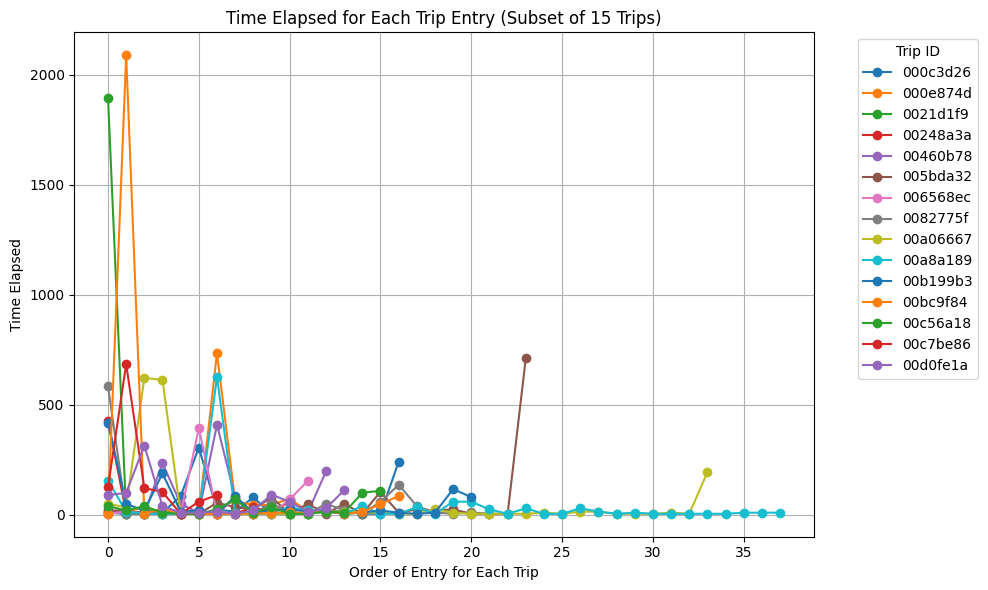

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_time_elapsed_by_trip(df):
    plt.figure(figsize=(10, 6))

    # Iterate over each unique trip_id and plot its time_elapsed values
    for trip_id in df['trip_id'].unique():
        trip_data = df[df['trip_id'] == trip_id].copy()
        # Generate an x-axis value based on the order of the occurrences
        trip_data['x_order'] = range(len(trip_data))

        truncated_trip_id = trip_id[:8]  # Use the first 8 characters of the trip_id
        
        # Use the x_order as x-axis values and time_elapsed as y-axis values
        plt.plot(trip_data['x_order'], trip_data['time_elapsed'], marker='o', label=truncated_trip_id)

    # Add labels and title
    plt.xlabel('Order of Entry for Each Trip')
    plt.ylabel('Time Elapsed')
    plt.title('Time Elapsed for Each Trip Entry (Subset of 15 Trips)')
    plt.legend(title='Trip ID', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot for better readability
    plt.tight_layout()
    plt.grid(True)

    # Show the plot
    plt.show()


# Assume stationary_df is your original DataFrame with all trip data
# Select a subset of 15 unique trip IDs
subset_trip_ids = stationary_df['trip_id'].unique()[:15]

# Filter the DataFrame to include only these trip IDs (with duplicates)
subset_df = stationary_df[stationary_df['trip_id'].isin(subset_trip_ids)]

# Call the function with the subset DataFrame
plot_time_elapsed_by_trip(subset_df)


##### Stationarity Detection for a single trip

In [40]:
# Specify the trip_id you want to filter
trip_id = "0595015a0e01509f3e2e5585b3f55ee76354d3b2d3919726c2c1ffbce0b8c049"

# Filter the DataFrame for the given trip_id
data = df[df['trip_id'] == trip_id]

In [91]:
import numpy as np
import pandas as pd

def detect_stationary_interval_single_trip(df, output_path='stationary_intervals_single_trip_no_smoothing__2.csv'):
    results = []
    for index, row in df.iterrows():
        trip_id = row['trip_id']
        lats = np.array(row['lats'])
        lngs = np.array(row['lngs'])
        time_gap = np.array(row['time_gap'])
        
        # Compute differences between consecutive points directly from lat/lng arrays
        lat_diff = np.abs(np.diff(lats))
        lng_diff = np.abs(np.diff(lngs))

        # Identify stationary intervals (where there is no change in both lat and lng)
        stationary_indices = np.where((lat_diff == 0) & (lng_diff == 0))[0]
        
        # Group consecutive stationary indices into intervals
        if len(stationary_indices) > 0:
            start_idx = stationary_indices[0]
            for i in range(1, len(stationary_indices)):
                # If the current index is not consecutive, close the interval
                if stationary_indices[i] != stationary_indices[i - 1] + 1:
                    end_idx = stationary_indices[i - 1]
                    # Save the interval only if it has more than one index
                    if end_idx > start_idx:
                        interval = {
                            "trip_id": trip_id,
                            "start_idx": int(start_idx),
                            "end_idx": int(end_idx),
                            "start_lat": float(lats[start_idx]),
                            "start_lng": float(lngs[start_idx]),
                            "end_lat": float(lats[end_idx]),
                            "end_lng": float(lngs[end_idx]),
                            "time_elapsed": float(time_gap[end_idx] - time_gap[start_idx])
                        }
                        results.append(interval)
                    # Start a new interval
                    start_idx = stationary_indices[i]
            # Add the last interval if it has more than one index
            end_idx = stationary_indices[-1]
            if end_idx > start_idx:
                interval = {
                    "trip_id": trip_id,
                    "start_idx": int(start_idx),
                    "end_idx": int(end_idx),
                    "start_lat": float(lats[start_idx]),
                    "start_lng": float(lngs[start_idx]),
                    "end_lat": float(lats[end_idx]),
                    "end_lng": float(lngs[end_idx]),
                    "time_elapsed": float(time_gap[end_idx] - time_gap[start_idx])
                }
                results.append(interval)

    # Convert results to a DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_path, index=False)

    print(f"Stationary intervals saved to {output_path}")

detect_stationary_interval_single_trip(data)


Stationary intervals saved to stationary_intervals_single_trip_no_smoothing__2.csv


##### Coordinates from the Pooling dataset and the Pickup_df

In [92]:
# extract the entry where the booking_id = 000c3d26955e90c6218695a72ae4c3255580319a1cb8ac045bf733379c9e2bdd
match = df_pooling[df_pooling['booking_id'] == '000e874d4760fe8abee13dafdfbaf304ad4964a7f2f2e7ede42db516dec685d7']
print(match['wait_time_at_merchant'] * 60)
print(match['pickup_latitude'], match['pickup_longitude'])

62444    748.8
Name: wait_time_at_merchant, dtype: float64
62444    31.976
Name: pickup_latitude, dtype: float64 62444    35.948
Name: pickup_longitude, dtype: float64


In [93]:
# search for the trip_id 0595015a0e01509f3e2e5585b3f55ee76354d3b2d3919726c2c1ffbce0b8c049 in pickup_df
pickup_df[pickup_df['trip_id'] == '000e874d4760fe8abee13dafdfbaf304ad4964a7f2f2e7ede42db516dec685d7']

trip_id  pickup_lat  pickup_lng
1  000e874d4760fe8abee13dafdfbaf304ad4964a7f2f2e7...      31.976      35.949

##### Insight: Inner joining with the pooling dataset made us lose a lot of data

In [94]:
print(len(matching_df))
print(len(non_matching_entries))
print(len(combined_df_no_pickup_df))


4964
1492
5831


In [95]:
print(len(longest_intervals_df))

5839


In [96]:
longest_intervals_df.columns

Index(['trip_id', 'start_idx', 'end_idx', 'start_lat', 'start_lng', 'end_lat',
       'end_lng', 'time_elapsed'],
      dtype='object')

In [97]:
df.columns

Index(['trip_id', 'time_gap', 'dist', 'lats', 'driverID', 'weekID', 'timeID',
       'dateID', 'lngs', 'dist_gap', 'trip_time', 'merchant_id'],
      dtype='object')

In [98]:
matching_df.columns

Index(['trip_id', 'stationary_df_lat', 'stationary_df_lng', 'pooling_df_lat',
       'pooling_df_lng'],
      dtype='object')

In [99]:
# # drop columns from df that are merchant_id, merchant_id_x, merchant_id_y
# df.drop(columns=['merchant_id', 'merchant_id_x', 'merchant_id_y'], inplace=True)

In [110]:
# drop merchant_id column from df
df.drop(columns=['merchant_id'], inplace=True)

In [111]:
df.columns

Index(['trip_id', 'time_gap', 'dist', 'lats', 'driverID', 'weekID', 'timeID',
       'dateID', 'lngs', 'dist_gap', 'trip_time'],
      dtype='object')

In [101]:
# extract entries from df that have existing trip_id in matching_df
df_full_matching = df[df['trip_id'].isin(matching_df['trip_id'])]

In [102]:
df_full_matching.columns

Index(['trip_id', 'time_gap', 'dist', 'lats', 'driverID', 'weekID', 'timeID',
       'dateID', 'lngs', 'dist_gap', 'trip_time', 'merchant_id'],
      dtype='object')

In [103]:
len(matching_df)

4964

In [104]:
len(df)

5839

In [112]:
len(df_full_matching)

4964

In [106]:
# New Hook:
# We want to segment the trips into three different segments.
# 1. The first segment is from the start of the trip to the start_idx
# 2. The second segment is from the start_idx to the end_idx
# 3. The third segment is from the end_idx to the end of the trip
# start and end idx is saved in the longest_intervals_df
# change the values of all attributes after splitting

# Second Segment Dataframe should have the time_elapsed (wait time) and the coordinates, trip_id, driverID, weekid, timeId, dateID, 
# time_gap list (all but the distances or just make them zero)



In [ ]:
# Columns in df: 
# ['trip_id', 'time_gap', 'dist', 'lats', 'driverID', 'weekID', 'timeID', 'dateID', 'lngs', 'dist_gap', 'trip_time']

#### Split trips based on stationarity
TODO

In [ ]:
print(df.columns)
print(longest_intervals_df.columns)

Index(['trip_id', 'time_gap', 'dist', 'lats', 'driverID', 'weekID', 'timeID',
       'dateID', 'lngs', 'dist_gap', 'trip_time', 'merchant_id'],
      dtype='object')
Index(['trip_id', 'start_idx', 'end_idx', 'pickup_lat', 'pickup_lng',
       'time_elapsed'],
      dtype='object')


In [36]:
# display the longest_intervals_df for trip 000c3d26955e90c6218695a72ae4c3255580319a1cb8ac045bf733379c9e2bdd
longest_intervals_df[longest_intervals_df['trip_id'] == '000c3d26955e90c6218695a72ae4c3255580319a1cb8ac045bf733379c9e2bdd']

trip_id  start_idx  end_idx  \
0  000c3d26955e90c6218695a72ae4c3255580319a1cb8ac...         24       86   

   pickup_lat  pickup_lng  time_elapsed  
0       31.95      35.872         594.0

In [33]:
def segment_trips(df, longest_intervals_df):
    road_list = []
    second_segment_list = []

    # Iterate over each entry in the df dataframe
    for index, row in df.iterrows():
        trip_id = row['trip_id']
        interval = longest_intervals_df[longest_intervals_df['trip_id'] == trip_id]
        lats = row['lats']
        lngs = row['lngs']
        time_gap = row['time_gap']
        dist_gap = row['dist_gap']

        if not interval.empty:
            start_idx = interval['start_idx'].values[0]
            end_idx = interval['end_idx'].values[0]

            # Segment the trip into three parts
            first_segment = {
                'trip_id': trip_id,
                'time_gap': time_gap[:start_idx],
                'dist': dist_gap[start_idx - 1] if start_idx > 0 else 0,
                'trip_time': time_gap[start_idx - 1] if start_idx > 0 else 0,
                'driverID': row['driverID'],
                'weekID': row['weekID'],
                'timeID': row['timeID'],
                'dateID': row['dateID'],
                'dist_gap': dist_gap[:start_idx],
                'lats': lats[:start_idx],
                'lngs': lngs[:start_idx],
                'time_offset': 0,
                'segmentID': 1
            }
            
            stationary_time_gap = time_gap[start_idx:end_idx+1]
            # subtract each element in the stationary_time_gap list by the first element
            if len(stationary_time_gap) > 0:
                stationary_time_gap = [time - stationary_time_gap[0] for time in stationary_time_gap]
            else:
                stationary_time_gap = []

            stationary_dist_gap = dist_gap[start_idx:end_idx+1]
            # subtract each element in the stationary_dist_gap list by the first element
            if len(stationary_dist_gap) > 0:
                stationary_dist_gap = [dist - stationary_dist_gap[0] for dist in stationary_dist_gap]
            else:
                stationary_dist_gap = []
        
            second_segment = {
                'trip_id': trip_id,
                'time_gap': stationary_time_gap,
                'dist': stationary_dist_gap[-1] if len(stationary_dist_gap) > 0 else 0,
                'trip_time': stationary_time_gap[-1] if len(stationary_time_gap) > 0 else 0,
                'driverID': row['driverID'],
                'weekID': row['weekID'],
                'timeID': row['timeID'],
                'dateID': row['dateID'],
                'dist_gap': stationary_dist_gap,
                'lats': lats[start_idx:end_idx+1],
                'lngs': lngs[start_idx:end_idx+1],
                'time_offset': time_gap[start_idx],
                'merchant': row['merchant_id']
            }
            
            new_time_gap = time_gap[end_idx+1:]
            # subtract each element in the new_time_gap list by the first element
            if len(new_time_gap) > 0:
                new_time_gap = [time - new_time_gap[0] for time in new_time_gap]
            else:
                new_time_gap = []

            new_dist_gap = dist_gap[end_idx+1:]
            # subtract each element in the new_dist_gap list by the first element
            if len(new_dist_gap) > 0:
                new_dist_gap = [dist - new_dist_gap[0] for dist in new_dist_gap]
            else:
                new_dist_gap = []
            
            third_segment = {
                'trip_id': trip_id,
                'time_gap': new_time_gap,
                'dist': new_dist_gap[-1] if len(new_dist_gap) > 0 else 0,
                'trip_time': new_time_gap[-1] if len(new_time_gap) > 0 else 0,
                'driverID': row['driverID'],
                'weekID': row['weekID'],
                'timeID': row['timeID'],
                'dateID': row['dateID'],
                'dist_gap': new_dist_gap,
                'lats': lats[end_idx+1:],
                'lngs': lngs[end_idx+1:],
                'time_offset': time_gap[end_idx+1],
                'segmentID': 3
            }
        else:
            print(f"No interval found for trip_id: {trip_id}")

        # add the first and third segments to the road_list
        if len(first_segment['time_gap']) > 1:
            road_list.append(first_segment)

        if len(third_segment['time_gap']) > 1:
            road_list.append(third_segment)

        # add the second segment to the second_segment_list
        if len(second_segment['time_gap']) > 1:
            second_segment_list.append(second_segment)

    # Convert the lists to DataFrames
    road_df = pd.DataFrame(road_list)
    second_segment_df = pd.DataFrame(second_segment_list)

    return road_df, second_segment_df


In [34]:
road_df, second_segment_df = segment_trips(df, longest_intervals_df)



road_json = road_df.to_dict(orient='records')
second_seg_json = second_segment_df.to_dict(orient='records')

with open('Segmented_Trips_Filtered_01_28.json', 'w') as file:
    for json_obj in road_json:
        json.dump(json_obj, file)
        file.write('\n')

with open('Merchants_Segments_Filtered_01_28.json', 'w') as file:
    for json_obj in second_seg_json:
        json.dump(json_obj, file)
        file.write('\n')
        
print("Segments 1 & 3 saved to 'Segmented_Trips_Filtered_01_28.json'")
print("Segment 2 with wait times saved to 'Merchants_Segments_Filtered_01_28.json'")


print(road_df.columns)
print(second_segment_df.columns)

IndexError: list index out of range

In [59]:
# Step 1: Find trips that have only one occurrence in road_df
single_occurrence_trips = road_df['trip_id'].value_counts()
single_occurrence_trips = single_occurrence_trips[single_occurrence_trips == 1].index

# Step 2: Filter the DataFrame to include only trips that have one occurrence
filtered_single_trips_df = road_df[road_df['trip_id'].isin(single_occurrence_trips)]

# Step 3: Filter further to ensure segmentID is 3
filtered_single_trips_segment3_df = filtered_single_trips_df[filtered_single_trips_df['segmentID'] == 1]

# Step 4: Save all the filtered data into a single CSV file
output_csv = 'single_occurrence_segment1_trips.csv'
filtered_single_trips_segment3_df.to_csv(output_csv, index=False)

print(f"All single occurrence trips with segmentID 1 saved to {output_csv}")


All single occurrence trips with segmentID 1 saved to single_occurrence_segment1_trips.csv


#### Old Splitting Logic

In [12]:

# # Function to save trips into JSON format
# def save_trips_to_json(trips, file_name):
#     with open(file_name, 'w') as f:
#         for trip in trips:
#             f.write(json.dumps(trip) + '\n')  # Write each object as a new line


# # Prepare a list to store split trips
# split_trips = []


# # Iterate over each trip and split based on the given conditions
# for index, row in df.iterrows():
#     trip_id = row['trip_id']
#     lats = row['lats']
#     lngs = row['lngs']
#     time_gap = row['time_gap']
#     dist_gap = row['dist_gap']
#     driverID = row['driverID']
#     weekID = row['weekID']
#     timeID = row['timeID']
#     dateID = row['dateID']
    
#     # Find the corresponding target_time_gap and last_stationary_index from previous results
#     result = next((r for r in results if r['trip_id'] == trip_id), None)
    
#     if result:
#         target_time_gap = result['arrived_at_merch_time_gap']
#         last_stationary_index = result['last_stationary_index']
#         last_stationary_time_gap = result['last_stationary_time_gap']
#         driver_to_merch_index = result['driver_to_merch_index']
        
#         # Split trip A (from the beginning to closest to target_time_gap)
#         trip_A = {
#             'trip_id': f"{trip_id}A",
#             'time_gap': time_gap[:driver_to_merch_index + 1],
#             'dist': dist_gap[driver_to_merch_index],  # Use the last dist_gap in trip A
#             'lats': lats[:driver_to_merch_index + 1],
#             'lngs': lngs[:driver_to_merch_index + 1],
#             'driverID': driverID,
#             'weekID': weekID,
#             'timeID': timeID,  # Original timeID
#             'dateID': dateID,
#             'time': time_gap[driver_to_merch_index],  # Use the last time_gap in trip A
#             'dist_gap': dist_gap[:driver_to_merch_index + 1]
#         }
        
#         # Split trip B (from last_stationary_index onwards)
#         trip_B = {
#             'trip_id': f"{trip_id}B",
#             'time_gap': time_gap[last_stationary_index:],  # Starting from the last stationary point
#             'dist': dist_gap[last_stationary_index],  # Use the last dist_gap in trip B
#             'lats': lats[last_stationary_index:],
#             'lngs': lngs[last_stationary_index:],
#             'driverID': driverID,
#             'weekID': weekID,
#             'timeID': timeID + last_stationary_time_gap,  # Adjusted timeID
#             'dateID': dateID,
#             'time': time_gap[-1],  # Use the last time_gap in trip B
#             'dist_gap': dist_gap[last_stationary_index:]
#         }
        
#         # Append the split trips to the list
#         split_trips.append(trip_A)
#         split_trips.append(trip_B)

# # Save the split trips to a new JSON file
# output_json_file = 'split_trips_2024-01-28.json'
# save_trips_to_json(split_trips, output_json_file)

# print(f"Split trips saved to {output_json_file}")


Split trips saved to split_trips_2024-01-28.json


In [13]:
# #Load split data from each JSON file
# split_data = []

# split_file_name = 'split_trips_2024-01-28.json'

# # Read the file line by line and load each JSON object
# with open(split_file_name, 'r') as file:
#     for line in file:
#         split_data.append(json.loads(line))

# # Create a DataFrame
# df_split = pd.DataFrame(split_data)


# # Step 1: Drop the 'time_diff' attribute if it exists
# if 'time_diff' in df_split.columns:
#     df_split.drop('time_diff', axis=1, inplace=True)

# # # Step 2: Redefine the features after dropping 'time_diff'
# # X = df_features.drop(columns=['time_diff'], errors='ignore')

# # Calculate trip time in seconds
# df_split['trip_time'] = df_split['time']

# # Now, drop the 'time' column
# df_split.drop(columns=['time'], inplace=True)

# # Drop rows with missing values (if any)
# df_split.dropna(inplace=True)

###### Find difference between pooling coordinates and actual coords

In [14]:
# import math

# # Haversine formula to calculate distance between two lat/lng points (in kilometers)
# def haversine(lat1, lon1, lat2, lon2):
#     # Convert latitude and longitude from degrees to radians
#     lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

#     # Haversine formula
#     dlat = lat2 - lat1 
#     dlon = lon2 - lon1 
#     a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
#     c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a)) 
#     r = 6371  # Radius of Earth in kilometers
#     return r * c  # Returns distance in kilometers

# # Prepare a list to store the additional results for the new CSV
# index_diff_results = []

# # Iterate over the results from the previous processing
# for result in results:
#     trip_id = result['trip_id']
#     driver_to_merch_index = result['driver_to_merch_index']
    
#     # Find the matching entry in the pooling data for this trip_id
#     match = df_pooling[df_pooling['booking_id'] == trip_id]
    
#     if not match.empty:
#         # Get the pickup coordinates from the pooling data
#         pickup_lat = match['pickup_latitude'].iloc[0]
#         pickup_lng = match['pickup_longitude'].iloc[0]
        
#         # Find the first instance of the pickup coordinates in the lats and lngs of the trip
#         lats = df[df['trip_id'] == trip_id]['lats'].values[0]
#         lngs = df[df['trip_id'] == trip_id]['lngs'].values[0]
        
#         # Find the index of the first occurrence of the pickup coordinates
#         try:
#             first_pickup_index = next(i for i, (lat, lng) in enumerate(zip(lats, lngs)) if lat == pickup_lat and lng == pickup_lng)
#         except StopIteration:
#             first_pickup_index = None  # Handle case where the coordinates are not found
        
#         if first_pickup_index is not None:
#             # Calculate the index difference
#             index_difference = driver_to_merch_index - first_pickup_index
            
#             # Get the coordinates at driver_to_merch_index
#             driver_to_merch_lat = lats[driver_to_merch_index]
#             driver_to_merch_lng = lngs[driver_to_merch_index]
            
#             # Calculate the distance difference using the Haversine formula
#             distance_difference = haversine(pickup_lat, pickup_lng, driver_to_merch_lat, driver_to_merch_lng)
            
#             # Append the result to the list
#             index_diff_results.append({
#                 'trip_id': trip_id,
#                 'first_pickup_lat': pickup_lat,
#                 'first_pickup_lng': pickup_lng,
#                 'driver_to_merch_lat': driver_to_merch_lat,
#                 'driver_to_merch_lng': driver_to_merch_lng,
#                 'index_difference': index_difference,
#                 'distance_difference_km': round(distance_difference, 3),  # Distance in kilometers, rounded to 3 decimal places
#                 'driver_to_merch_index': driver_to_merch_index,
#                 'first_pickup_index': first_pickup_index
#             })

# # Convert the new results to a DataFrame and save as a new CSV
# index_diff_df = pd.DataFrame(index_diff_results)
# new_csv_file = 'index_distance_difference_results.csv'
# index_diff_df.to_csv(new_csv_file, index=False)

# print(f"New CSV file saved as {new_csv_file}")


New CSV file saved as index_distance_difference_results.csv


### Step 4: Order rush hours analysis - number of orders per time segment

In [19]:
# Define 2-hour segment ranges (in minutes)
two_hour_segments = [(i * 120, (i + 1) * 120) for i in range(12)]  # Each tuple is a (start, end) range in minutes
two_hour_labels = [f"{str(i*2).zfill(2)}:00 - {str(i*2+2).zfill(2)}:00" for i in range(12)]  # Two-hour labels in "HH:MM - HH:MM" format

# Function to determine which 2-hour segment a timeID belongs to
def get_two_hour_segment(timeID):
    for idx, (start, end) in enumerate(two_hour_segments):
        if start <= timeID < end:
            return two_hour_labels[idx]  # Return the corresponding 2-hour label
    return None  # Return None if the timeID is outside the 0-1440 range (but it shouldn't happen)

# Apply the 2-hour segment function to assign each row to a 2-hour segment based on timeID
road_df['two_hour_segment'] = road_df['timeID'].apply(get_two_hour_segment)

# Group by the 'two_hour_segment' column and count the number of rows (orders) in each segment
orders_per_two_hour_segment = road_df.groupby('two_hour_segment').size().reset_index(name='order_count')

# Write the result to a CSV file
# output_file_path = 'split_orders_per_two_hour_segment.csv'
# orders_per_two_hour_segment.to_csv(output_file_path, index=False)

# print(f"Results have been saved to {output_file_path}")


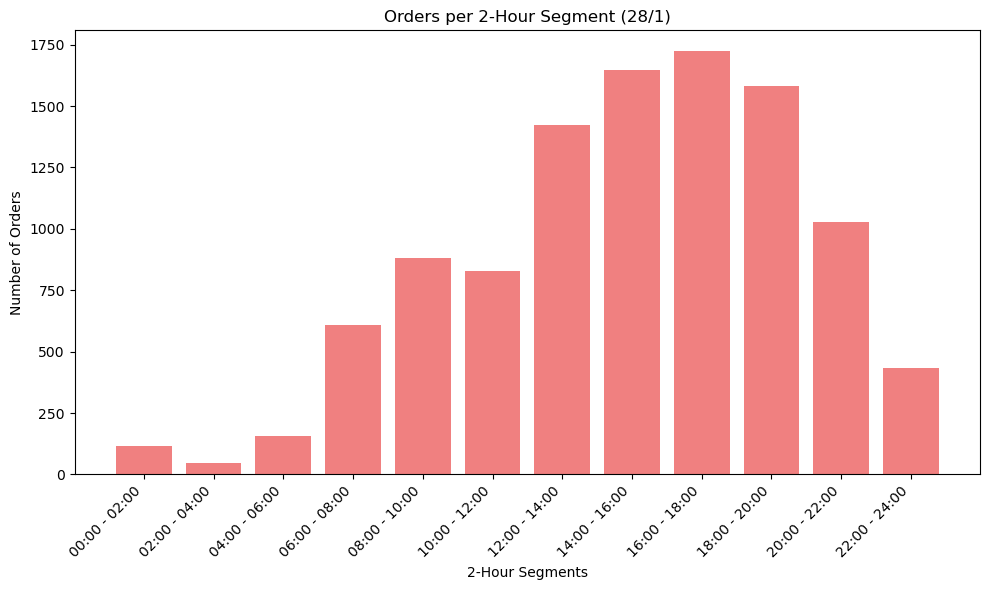

In [20]:
plt.figure(figsize=(10, 6))
plt.bar(orders_per_two_hour_segment['two_hour_segment'], orders_per_two_hour_segment['order_count'], color='lightcoral')
plt.xlabel('2-Hour Segments')
plt.ylabel('Number of Orders')
plt.title('Orders per 2-Hour Segment (28/1)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

In [17]:
# Define 1-hour segment ranges (in minutes)
hour_segments = [(i * 60, (i + 1) * 60) for i in range(24)]  # Each tuple is a (start, end) range in minutes
hour_labels = [f"{str(i).zfill(2)}:00 - {str(i+1).zfill(2)}:00" for i in range(24)]  # Hour labels in "HH:MM - HH:MM" format

# Function to determine which hour segment a timeID belongs to
def get_hour_segment(timeID):
    for idx, (start, end) in enumerate(hour_segments):
        if start <= timeID < end:
            return hour_labels[idx]  # Return the corresponding hour label
    return None  # Return None if the timeID is outside the 0-1440 range (but it shouldn't happen)

# Apply the hour segment function to assign each row to an hourly segment based on timeID
df['hour'] = df['timeID'].apply(get_hour_segment)

# Group by the 'hour' column and count the number of rows (orders) in each hour
orders_per_hour = df.groupby('hour').size().reset_index(name='order_count')

# Write the result to a CSV file
output_file_path = 'orders_per_hour_segment.csv'
orders_per_hour.to_csv(output_file_path, index=False)

print(f"Results have been saved to {output_file_path}")


Results have been saved to orders_per_hour_segment.csv


### Step 5: Clustering start and end coordinates of trips

In [21]:
total_coords = road_df['lats'].apply(len).sum()

print(f"Total number of coordinates in the DataFrame: {total_coords}")

Total number of coordinates in the DataFrame: 1053779


In [23]:

all_lats = [lat for sublist in road_df['lats'] for lat in sublist]
all_lngs = [lng for sublist in road_df['lngs'] for lng in sublist]
coords = np.array(list(zip(all_lats, all_lngs)))


num_clusters = 250  
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(coords)
cluster_labels = kmeans.labels_

coord_to_cluster = dict(zip(map(tuple, coords), cluster_labels))

def get_cluster_id(lat, lon):
    return coord_to_cluster.get((lat, lon), None)


##### Trips that have the same src and dst within the same cluster (with Visualization) Different visuals

In [ ]:
df['start_cluster'] = [get_cluster_id(row['lats'][0], row['lngs'][0]) for _, row in df.iterrows()]
df['end_cluster'] = [get_cluster_id(row['lats'][-1], row['lngs'][-1]) for _, row in df.iterrows()]

# Step 3: Check if a trip has the same starting and destination cluster
df['same_cluster'] = df['start_cluster'] == df['end_cluster']

# Step 4: Prepare map
average_lat = sum(all_lats) / len(all_lats)
average_lon = sum(all_lngs) / len(all_lngs)
m = folium.Map(location=[average_lat, average_lon], zoom_start=12)

# Add clustering to handle the large number of points
marker_cluster = MarkerCluster().add_to(m)

# Step 5: Create and add polygons for each cluster
cluster_points = {}
for coord, label in zip(coords, cluster_labels):
    if label not in cluster_points:
        cluster_points[label] = []
    cluster_points[label].append(coord)

for label, points in cluster_points.items():
    if len(points) > 1:
        # Create a shapely polygon from the points
        multipoint = MultiPoint(points)
        convex_hull = multipoint.convex_hull
        coords = np.array(convex_hull.exterior.coords)
        # Convert to a list of lists for folium
        folium.Polygon(locations=coords.tolist(),
                        color='blue', fill=True, 
                        fill_color='blue', 
                        fill_opacity=0.2, 
                        tooltip=folium.Tooltip(f"Cluster {label}")  
                        ).add_to(m)

for idx, row in df.iterrows():
    if row['same_cluster']:
        color = "red"
        weight = 3
    # else:
    #     color = "blue"
    #     weight = 2.5

        folium.Marker([row['lats'][0], row['lngs'][0]], icon=folium.Icon(color=color), tooltip=f'Trip ID: {row["trip_id"]}').add_to(marker_cluster)
        folium.Marker([row['lats'][-1], row['lngs'][-1]], icon=folium.Icon(color=color), tooltip=f'Trip ID: {row["trip_id"]}').add_to(marker_cluster)
        folium.PolyLine([
            [row['lats'][0], row['lngs'][0]],  # First point
            [row['lats'][-1], row['lngs'][-1]]  # Last point
        ], color=color, weight=weight, opacity=1).add_to(m)

# Save the map to an HTML file
output_map = 'clustered_map_same_cluster_trips.html'
m.save(output_map)

print(f"Map has been saved to {output_map}")

# Print trips with the same starting and destination clusters
print("Trips with the same starting and destination clusters:")
same_cluster_trips = df[df['same_cluster']]
print(same_cluster_trips[['trip_id', 'start_cluster', 'end_cluster']])

##### Cluster - Split trips

In [24]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans
import numpy as np
from shapely.geometry import MultiPoint
from shapely.ops import unary_union

# Example DataFrame format
# df = pd.DataFrame({'lats': [[25.276987, 25.276998], [25.285557, 25.293304]], 
#                    'lngs': [[55.296249, 55.296259], [55.315227, 55.320907]],
#                    'trip_id': [1, 2]})

# Step 1: Flatten the coordinates for clustering
all_lats = [lat for sublist in road_df['lats'] for lat in sublist]
all_lngs = [lng for sublist in road_df['lngs'] for lng in sublist]
coords = np.array(list(zip(all_lats, all_lngs)))

# Perform clustering
num_clusters = 400  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(coords)
cluster_labels = kmeans.labels_

# Create a mapping from coordinates to cluster labels
coord_to_cluster = dict(zip(map(tuple, coords), cluster_labels))

# Step 2: Determine clusters for initial and destination points
def get_cluster_id(lat, lon):
    return coord_to_cluster.get((lat, lon), None)

road_df['start_cluster'] = [get_cluster_id(row['lats'][0], row['lngs'][0]) for _, row in road_df.iterrows()]
road_df['end_cluster'] = [get_cluster_id(row['lats'][-1], row['lngs'][-1]) for _, row in road_df.iterrows()]

# Step 3: Check if a trip has the same starting and destination cluster
road_df['same_cluster'] = road_df['start_cluster'] == road_df['end_cluster']

# Step 4: Prepare map
average_lat = sum(all_lats) / len(all_lats)
average_lon = sum(all_lngs) / len(all_lngs)
m = folium.Map(location=[average_lat, average_lon], zoom_start=12)

# Add clustering to handle the large number of points
marker_cluster = MarkerCluster().add_to(m)

# Step 5: Create and add polygons for each cluster
cluster_points = {}
for coord, label in zip(coords, cluster_labels):
    if label not in cluster_points:
        cluster_points[label] = []
    cluster_points[label].append(coord)

for label, points in cluster_points.items():
    if len(points) > 1:
        # Create a shapely polygon from the points
        multipoint = MultiPoint(points)
        convex_hull = multipoint.convex_hull
        coords = np.array(convex_hull.exterior.coords)
        # Convert to a list of lists for folium
        folium.Polygon(locations=coords.tolist(),
                        color='blue', fill=True, 
                        fill_color='blue', 
                        fill_opacity=0.2, 
                        tooltip=folium.Tooltip(f"Cluster {label}")  
                        ).add_to(m)

for idx, row in road_df.iterrows():
    if row['same_cluster']:
        color = "red"
        weight = 3
    # else:
    #     color = "blue"
    #     weight = 2.5

        folium.Marker([row['lats'][0], row['lngs'][0]], icon=folium.Icon(color=color), tooltip=f'Trip ID: {row["trip_id"]}').add_to(marker_cluster)
        folium.Marker([row['lats'][-1], row['lngs'][-1]], icon=folium.Icon(color=color), tooltip=f'Trip ID: {row["trip_id"]}').add_to(marker_cluster)
        folium.PolyLine([
            [row['lats'][0], row['lngs'][0]],  # First point
            [row['lats'][-1], row['lngs'][-1]]  # Last point
        ], color=color, weight=weight, opacity=1).add_to(m)

# Save the map to an HTML file
output_map = 'Segmented_Clustering.html'
m.save(output_map)

print(f"Map has been saved to {output_map}")

# Print trips with the same starting and destination clusters
print("Trips with the same starting and destination clusters:")
same_cluster_trips = road_df[road_df['same_cluster']]
print(same_cluster_trips[['trip_id', 'start_cluster', 'end_cluster']])

Map has been saved to Segmented_Clustering.html
Trips with the same starting and destination clusters:
                                                 trip_id  start_cluster  \
12     00a066677fc7a691f0a8d256ac8a94dabefe8d7b2031ae...            286   
20     00c7be86f7d167ae506402a77b0d7fecf1b65e3a06e947...            248   
24     00d9849d6c36a355b342547c966fc95d2194652cf86a93...            156   
28     00e4d3cf28cabbccaccb4f9a9a55ade0b25a22e7705f97...             97   
30     00f752a5963f3f1e75c1631223d60ed1421f742fc7ebc6...            273   
...                                                  ...            ...   
10410  fe7e61f4b9f1afb5fa0dbf400d738ae1bf70ca828231f1...            143   
10445  ffb0d52546bc2935cf9e1d80373698a705999a275c5d37...             75   
10448  ffb51d3ebefb18b734644cd838524b145094cbd186dd0d...            212   
10452  ffc909f7fc603cc39d48138a3f8787e44b4a2c674d06f9...            248   
10460  fff6f3db1883b2a1a8077ca2ab8ca5d8fd0b564cd1047f...            158 

##### Listing all trips that share the same src and dst clusters

In [25]:
df_diff_clusters = road_df[road_df['same_cluster'] == False]

In [26]:
trip_categories = df_diff_clusters.groupby(['start_cluster', 'end_cluster']).apply(lambda x: x['trip_id'].tolist())
# Print categorized trips
print("Categorized trips:")
for (start_cluster, end_cluster), trips in trip_categories.items():
    print(f"From cluster {start_cluster} to cluster {end_cluster}: {len(trips)} trips - {trips}")

Categorized trips:
From cluster 0 to cluster 9: 1 trips - ['8a8a22b897fd0efe8f833375199cc4ecccde5fe3fc65c7a1bb4e1885b4aa3126']
From cluster 0 to cluster 26: 2 trips - ['8f95de0d3f1b0dba41797694fe15181ce82922c78fd01ae25bda8eaa31bc78cc', 'f13eb30896e291b75cfdad28797a14289326bc244b5a57bd70b1acc3f22dfd92']
From cluster 0 to cluster 44: 1 trips - ['5b82caaadd154439bdcb2b5ab9736b0ab672721254709c3b02d5dd1de6b9dbb2']
From cluster 0 to cluster 57: 1 trips - ['2b51e67129daeee40eacc01e57f00ff3169664b0f565c8e46b2ef4021116f2a8']
From cluster 0 to cluster 64: 1 trips - ['29089e0305373ff51bc5f6a58574a9e4478a386cc818206d0adabc4628aa1272']
From cluster 0 to cluster 65: 1 trips - ['6038a7752c90ff8f2ecf74b80674bbc96d4b1a0562a12e69b7ee1384df2a7ee9']
From cluster 0 to cluster 81: 1 trips - ['305dc71ad4a642963e93f2780302c06b4ab8cf20b502d50bc2facca9e3462f2f']
From cluster 0 to cluster 85: 1 trips - ['972d9288cc4d6df18f552825cfea6dfad227456a0064b639d0062853e3d8fee0']
From cluster 0 to cluster 89: 1 trips - ['

/var/folders/lj/pwyj2dkd2_j_jhxl5z4j87k80000gn/T/ipykernel_24409/1973078642.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trip_categories = df_diff_clusters.groupby(['start_cluster', 'end_cluster']).apply(lambda x: x['trip_id'].tolist())


In [23]:
# # Step 1: Create an empty list to store rows for concatenation
# rows_list = []

# # Step 2: Populate the list with the categorized trip information including time
# for (start_cluster, end_cluster), trips in trip_categories.items():
#     # Extract the 'time' for the corresponding trips
#     trip_times = df_diff_clusters[df_diff_clusters['trip_id'].isin(trips)]['trip_time'].tolist()
    
#     # Append a dictionary of the row data to the list
#     rows_list.append({
#         'start_cluster': start_cluster,
#         'end_cluster': end_cluster,
#         'trip_count': len(trips),
#         'trip_times': trip_times,  # Include trip times here
#         'trip_ids': trips
#     })

# # Step 3: Create a DataFrame from the rows list
# trip_categories_df = pd.DataFrame(rows_list)

# # Step 4: Save the DataFrame to a CSV file
# output_csv = 'categorized_trips_with_times_split.csv'
# trip_categories_df.to_csv(output_csv, index=False)

# print(f"Categorized trips data with times has been saved to {output_csv}")


Categorized trips data with times has been saved to categorized_trips_with_times_split.csv


In [24]:
# # Step 1: Create an empty list to store rows for concatenation
# rows_list = []

# # Step 2: Populate the list with the categorized trip information including time
# for (start_cluster, end_cluster), trips in trip_categories.items():
#     # Extract the 'time' for the corresponding trips
#     trip_times = df_diff_clusters[df_diff_clusters['trip_id'].isin(trips)]['trip_time'].tolist()

#     # Calculate the variance and standard deviation for the trip times in this category
#     if trip_times:  # Only calculate if there are trip times
#         variance = np.var(trip_times) / (60**2) # in minutes
#         std_dev = np.std(trip_times) / 60   # in minutes
#     else:
#         variance = None  # Handle empty cases
#         std_dev = None

#     # Append a dictionary of the row data to the list
#     rows_list.append({
#         'start_cluster': start_cluster,
#         'end_cluster': end_cluster,
#         'trip_count': len(trips),
#         'trip_times': trip_times,  # Include trip times here
#         'variance': round(variance,3),  # Add variance as a metric for time variation
#         'std': round(std_dev,3),   # Add standard deviation as a metric for time variation
#         'trip_ids': trips
#     })

# # Step 3: Create a DataFrame from the rows list
# trip_categories_df = pd.DataFrame(rows_list)

# # Step 4: Save the DataFrame to a CSV file
# output_csv = 'categorized_split_trips_with_time_std.csv'
# trip_categories_df.to_csv(output_csv, index=False)

# print(f"Categorized trips data with times and variance has been saved to {output_csv}")


Categorized trips data with times and variance has been saved to categorized_split_trips_with_time_std.csv


In [37]:
# Step 1: Create a unique identifier for each trip by combining 'trip_id' and 'segmentID'
df_diff_clusters['unique_trip'] = df_diff_clusters['trip_id'].astype(str) + '_' + df_diff_clusters['segmentID'].astype(str)

# Group trips by start cluster, end cluster, and two-hour segment
trip_categories = df_diff_clusters.groupby(['start_cluster', 'end_cluster', 'two_hour_segment']).apply(lambda x: x['unique_trip'].tolist())
rows_list = []

# Step 2: Populate the list with the categorized trip information including time
for (start_cluster, end_cluster, segment), trips in trip_categories.items():
    # Only consider trip categories with more than 1 trip
    if len(trips) > 1:
        # Extract the 'time' for the corresponding trips based on 'unique_trip'
        trip_times = df_diff_clusters[df_diff_clusters['unique_trip'].isin(trips)]['trip_time'].tolist()

        # Calculate the variance and standard deviation for the trip times in this category
        if trip_times:  # Only calculate if there are trip times
            variance = np.var(trip_times) / (60**2)  # in minutes
            std_dev = np.std(trip_times) / 60        # in minutes
        else:
            variance = None  # Handle empty cases
            std_dev = None

        # Append a dictionary of the row data to the list
        rows_list.append({
            'start_cluster': start_cluster,
            'end_cluster': end_cluster,
            'two_hour_segment': segment,
            'trip_count': len(trips),
            'trip_times': trip_times,  # Include trip times here
            'variance': round(variance, 3),  # Add variance as a metric for time variation
            'std': round(std_dev, 3),   # Add standard deviation as a metric for time variation
            'trip_ids': trips  # Use unique_trip to identify trips
        })

# Step 3: Create a DataFrame from the rows list
trip_categories_df = pd.DataFrame(rows_list)

# Save the DataFrame to a CSV file
output_csv = 'Clustered_Segmented_Trip_Variances.csv'
trip_categories_df.to_csv(output_csv, index=False)

print(f"Filtered trip categories with more than 1 trip saved to {output_csv}")


/var/folders/lj/pwyj2dkd2_j_jhxl5z4j87k80000gn/T/ipykernel_24409/3431320295.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff_clusters['unique_trip'] = df_diff_clusters['trip_id'].astype(str) + '_' + df_diff_clusters['segmentID'].astype(str)
/var/folders/lj/pwyj2dkd2_j_jhxl5z4j87k80000gn/T/ipykernel_24409/3431320295.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trip_categories = df_diff_clusters.groupby(['start_cluster', 'end_cluster', 'two_

Filtered trip categories with more than 1 trip saved to Clustered_Segmented_Trip_Variances.csv


##### Visualization of variances in times 

###### Extract Trips using IDs

In [25]:
import json

# List of trip IDs to extract
trip_ids_to_extract = [
    '36b56497519087a934fa8ecd479f61211ee10819358b7549026cfa5dfe7bdd09A',
    '40a7d815827f078e7d4b5127cab60797d29008dc15d12f9d368b1e92efbcfeb5A',
    '86add17348158cf120d7d6167c11a42b035ed3a3e4b55fed7f03c41dbfec8583A',
    '8919c6488f0ab96c04d4fa31fd3eb8669c91a852a65401a4c18b7b14390f77deB',
    '9453078b6d6403d40ae26ab3db70b89f0b3bed969ad0a69beb8ce10a3f24497fA',
    'e8780f825e5a118063ffb6776fdd3fbaa3723f73618408f6ad31f962e12ca2a3A'
]

# Input and output file paths
input_file = 'split_trips_2024-01-28.json'  # Replace with the actual input file path
output_file = 'extracted_trips_split_trips_2024-01-28.json'  # Output file

# List to store the extracted trips
extracted_trips = []

# Read the input JSON file line by line and extract trips that match the specified trip IDs
with open(input_file, 'r') as infile:
    for line in infile:
        line = line.strip()  # Remove any leading/trailing whitespace or newlines
        if line:  # Ensure the line is not empty
            try:
                trip_data = json.loads(line)
                # Check if the trip_id is in the list of trip_ids_to_extract
                if trip_data['trip_id'] in trip_ids_to_extract:
                    extracted_trips.append(trip_data)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON line: {line}")
                print(f"Error message: {e}")

# Write the extracted trips to the output JSON file with newline between objects
with open(output_file, 'w') as outfile:
    for trip in extracted_trips:
        outfile.write(json.dumps(trip) + '\n')

print(f"Extracted trips saved to {output_file}")


Extracted trips saved to extracted_trips_split_trips_2024-01-28.json


###### graphs

In [51]:
import plotly.express as px

# Step 1: Filter out clusters with only one trip
filtered_trip_categories_df = trip_categories_df[trip_categories_df['trip_count'] > 1]

# Step 2: Pivot the data to create a matrix of variance values
heatmap_data = filtered_trip_categories_df.pivot(index='start_cluster', columns='end_cluster', values='std')

# Step 3: Convert pivot table to a format suitable for Plotly (stacked format)
heatmap_data_stacked = heatmap_data.reset_index().melt(id_vars='start_cluster', value_name='std')

# Step 4: Create an interactive heatmap using Plotly with a valid colorscale (e.g., 'viridis')
fig = px.imshow(
    heatmap_data, 
    labels=dict(x="End Cluster", y="Start Cluster", color="STD"),
    x=heatmap_data.columns,
    y=heatmap_data.index,
    color_continuous_scale='viridis',  # Use a valid colorscale like 'viridis', 'inferno', 'plasma', etc.
    aspect="auto"
)

# Step 5: Add title and labels
fig.update_layout(
    title='Interactive Heatmap of Trip Time Standard Deviation',
    xaxis_title="End Cluster",
    yaxis_title="Start Cluster"
)

# Show the interactive plot
fig.show()


In [50]:
import plotly.express as px

# Step 1: Filter out clusters with only one trip
filtered_trip_categories_df = trip_categories_df[trip_categories_df['trip_count'] > 1]

# Step 2: Create a new column that combines start and end cluster to label the x-axis
filtered_trip_categories_df['cluster_pair'] = filtered_trip_categories_df['start_cluster'].astype(str) + '->' + filtered_trip_categories_df['end_cluster'].astype(str)

# Step 3: Create an interactive bar chart using Plotly
fig = px.bar(
    filtered_trip_categories_df,
    x='cluster_pair', 
    y='std', 
    title='Standard Deviation of Trip Times by Category (Excluding Clusters with Only 1 Trip)',
    labels={'std': 'Std of Trip Times', 'cluster_pair': 'Cluster Pairs'},
    hover_data=['trip_count'],  # Add additional hover data if needed
    color='std',  # Color based on variance
    color_continuous_scale='viridis'  # Choose a color scale
)

# Step 4: Customize the layout
fig.update_layout(
    xaxis_title="Start Cluster -> End Cluster",
    yaxis_title="Stand Deviation of Trip Times",
    xaxis_tickangle=-90,  # Rotate the x-axis labels for readability
    plot_bgcolor='white'
)

# Step 5: Show the interactive plot
fig.show()


/var/folders/lj/pwyj2dkd2_j_jhxl5z4j87k80000gn/T/ipykernel_78996/2773364086.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



##### Categorized MAP

In [38]:

# Step 1: Flatten the coordinates for clustering
all_lats = [lat for sublist in road_df['lats'] for lat in sublist]
all_lngs = [lng for sublist in road_df['lngs'] for lng in sublist]
coords = np.array(list(zip(all_lats, all_lngs)))

# Perform clustering
num_clusters = 400  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(coords)
cluster_labels = kmeans.labels_

# Create a mapping from coordinates to cluster labels
coord_to_cluster = dict(zip(map(tuple, coords), cluster_labels))

# Step 2: Determine clusters for initial and destination points
def get_cluster_id(lat, lon):
    return coord_to_cluster.get((lat, lon), None)

road_df['start_cluster'] = [get_cluster_id(row['lats'][0], row['lngs'][0]) for _, row in road_df.iterrows()]
road_df['end_cluster'] = [get_cluster_id(row['lats'][-1], row['lngs'][-1]) for _, row in road_df.iterrows()]

# Step 3: Calculate the number of distinct clusters connected to each cluster
road_df['same_cluster'] = road_df['start_cluster'] == road_df['end_cluster']

# Step 4: Prepare map
average_lat = sum(all_lats) / len(all_lats)
average_lon = sum(all_lngs) / len(all_lngs)
m = folium.Map(location=[average_lat, average_lon], zoom_start=12)

# Add clustering to handle the large number of points
marker_cluster = MarkerCluster().add_to(m)

# Step 5: Create and add polygons for each cluster and display the cluster number
cluster_points = {}
for coord, label in zip(coords, cluster_labels):
    if label not in cluster_points:
        cluster_points[label] = []
    cluster_points[label].append(coord)

for label, points in cluster_points.items():
    if len(points) > 1:
        # Create a shapely polygon from the points
        multipoint = MultiPoint(points)
        convex_hull = multipoint.convex_hull
        coords = np.array(convex_hull.exterior.coords)
        
        # Convert to a list of lists for folium and add the polygon
        folium.Polygon(
            locations=coords.tolist(),
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.2,
            tooltip=folium.Tooltip(f"Cluster {label}")
        ).add_to(m)
        
segment_colors = plt.cm.get_cmap('tab20', len(two_hour_labels))  # Using 'tab20' colormap
color_mapping = {two_hour_labels[i]: segment_colors(i) for i in range(len(two_hour_labels))}

# Convert the RGBA colors to HEX for Folium
def rgba_to_hex(rgba):
    return '#%02x%02x%02x' % (int(rgba[0]*255), int(rgba[1]*255), int(rgba[2]*255))

# Step 5: Loop through the categorized trips DataFrame and draw lines with different colors for each segment
for _, row in trip_categories_df.iterrows():
    start_cluster = row['start_cluster']
    end_cluster = row['end_cluster']
    segment = row['two_hour_segment']
    
    # Only add lines for distinct start and end clusters
    if start_cluster != end_cluster:
        # Get the coordinates for the start and end clusters
        start_coords = road_df.loc[road_df['start_cluster'] == start_cluster, ['lats', 'lngs']].values[0]
        end_coords = road_df.loc[road_df['end_cluster'] == end_cluster, ['lats', 'lngs']].values[0]
        
        # Get the color for the current 2-hour segment
        line_color = rgba_to_hex(color_mapping[segment])
        
        # Draw a line between the start and end clusters with the corresponding color for the time segment
        folium.PolyLine(
            locations=[[start_coords[0][0], start_coords[1][0]], [end_coords[0][-1], end_coords[1][-1]]],
            color=line_color, weight=3, opacity=0.7,
            tooltip=folium.Tooltip(f"Start: {start_cluster}, End: {end_cluster}<br>"
                                   f"Variance: {row['variance']:.2f}, Std Dev: {row['std']:.2f}, No Trips: {row['trip_count']}, Segment: {segment}")
        ).add_to(m)

# Step 6: Save the updated map with the lines categorized by 2-hour segments
output_map_with_segments = 'Segmented_Clustering_Categorized.html'
m.save(output_map_with_segments)

print(f"Map with categorized lines by segments has been saved to {output_map_with_segments}")


/var/folders/lj/pwyj2dkd2_j_jhxl5z4j87k80000gn/T/ipykernel_24409/3777589917.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  segment_colors = plt.cm.get_cmap('tab20', len(two_hour_labels))  # Using 'tab20' colormap


Map with categorized lines by segments has been saved to Segmented_Clustering_Categorized.html


##### Trips that have the same src and dst within the same cluster (with Visualization)

In [31]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans
import numpy as np

# Example DataFrame format
# df = pd.DataFrame({'lats': [[25.276987, 25.276998], [25.285557, 25.293304]], 
#                    'lngs': [[55.296249, 55.296259], [55.315227, 55.320907]],
#                    'trip_id': [1, 2]})

# Step 1: Flatten the coordinates for clustering
all_lats = [lat for sublist in df['lats'] for lat in sublist]
all_lngs = [lng for sublist in df['lngs'] for lng in sublist]
coords = np.array(list(zip(all_lats, all_lngs)))

# Perform clustering
num_clusters = 500  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(coords)
cluster_labels = kmeans.labels_

# Create a mapping from coordinates to cluster labels
coord_to_cluster = dict(zip(map(tuple, coords), cluster_labels))

# Step 2: Determine clusters for initial and destination points
def get_cluster_id(lat, lon):
    return coord_to_cluster.get((lat, lon), None)

df['start_cluster'] = [get_cluster_id(row['lats'][0], row['lngs'][0]) for _, row in df.iterrows()]
df['end_cluster'] = [get_cluster_id(row['lats'][-1], row['lngs'][-1]) for _, row in df.iterrows()]

# Step 3: Check if a trip has the same starting and destination cluster
df['same_cluster'] = df['start_cluster'] == df['end_cluster']

# Create a Folium map centered on the average lat and lon
average_lat = sum(all_lats) / len(all_lats)
average_lon = sum(all_lngs) / len(all_lngs)
m = folium.Map(location=[average_lat, average_lon], zoom_start=12)

# Add clustering to handle the large number of points
marker_cluster = MarkerCluster().add_to(m)

# Add each coordinate as a marker in the marker cluster
for idx, row in df.iterrows():
    if row['same_cluster']:
        # Highlight trips with the same start and end cluster
        color = "red"
        weight = 3
    # else:
    #     # Default color for other trips
    #     color = "blue"
    #     weight = 2.5

        folium.Marker([row['lats'][0], row['lngs'][0]], icon=folium.Icon(color=color), tooltip=f'Trip ID: {row["trip_id"]}').add_to(marker_cluster)
        folium.Marker([row['lats'][-1], row['lngs'][-1]], icon=folium.Icon(color=color), tooltip=f'Trip ID: {row["trip_id"]}').add_to(marker_cluster)
        folium.PolyLine([
            [row['lats'][0], row['lngs'][0]],  # First point
            [row['lats'][-1], row['lngs'][-1]]  # Last point
        ], color=color, weight=weight, opacity=1).add_to(m)

# Save the map to an HTML file
output_map = 'clustered_map_polyline.html'
m.save(output_map)

print(f"Map has been saved to {output_map}")

# Print trips with the same starting and destination clusters
print("Trips with the same starting and destination clusters:")
same_cluster_trips = df[df['same_cluster']]
print(same_cluster_trips[['trip_id', 'start_cluster', 'end_cluster']])


Map has been saved to clustered_map_polyline.html
Trips with the same starting and destination clusters:
                                                trip_id  start_cluster  \
31    01ff05c850fb030d8174a48d70a7327747dd0177030bc5...            212   
54    02b956d54997503a9e185001ec6c4db4c2a450ea8ba769...            221   
72    037cb3f62285a7f581a220635225d383a08eeb50fe2c73...            212   
84    03c48c560d1f99a0a1cc7b61e145a616b287be4b47abf9...            352   
110   04f89f54bc53022b70027183bde55e1927fa38606c005d...            300   
...                                                 ...            ...   
5484  f07627136ef177015f13a6a76e3449a84aea7a4ce132c4...            156   
5636  f77af4e9259f1386836fb93e3b424e2639c81a15a8e8c9...            229   
5649  f82b6c7a45db4fd93e76d73881343d2aeeec3fefb87640...            212   
5701  fa0e4afe16418d65606d05d964a79f262449243c5bcf46...              0   
5703  fa1cb5bf8cba91ec7799c6f78a61d80f580f08a0f04046...              0   

      

##### Basic clustering without polylines (Dynamic)

In [19]:
import pandas as pd
import folium
from folium.plugins import HeatMap, MarkerCluster

# Assuming df['lats'] and df['lngs'] are lists of coordinates
# Example DataFrame format:
# df = pd.DataFrame({'lats': [[25.276987, 25.276998], [25.285557, 25.293304]], 
#                    'lngs': [[55.296249, 55.296259], [55.315227, 55.320907]]})

# Step 1: Calculate the average latitude and longitude from all points
all_lats = [lat for sublist in df['lats'] for lat in sublist]  # Flatten the list of lats
all_lngs = [lng for sublist in df['lngs'] for lng in sublist]  # Flatten the list of lngs

average_lat = sum(all_lats) / len(all_lats)  # Compute average latitude
average_lon = sum(all_lngs) / len(all_lngs)  # Compute average longitude

# Step 2: Create a folium map centered on the average lat and lon
m = folium.Map(location=[average_lat, average_lon], zoom_start=12)

# Step 3: Add clustering to handle the large number of points
marker_cluster = MarkerCluster().add_to(m)

# Step 4: Add each coordinate as a marker in the marker cluster
for idx, row in df.iterrows():
    # for lat, lon in zip(row['lats'], row['lngs']):
    folium.Marker([row['lats'][0], row['lngs'][0]]).add_to(marker_cluster)
    folium.Marker([row['lats'][-1], row['lngs'][-1]]).add_to(marker_cluster)
    # folium.PolyLine([
    #     [row['lats'][0], row['lngs'][0]],  # First point
    #     [row['lats'][-1], row['lngs'][-1]]  # Last point
    # ], color="blue", weight=2.5, opacity=1).add_to(m)

# Step 5: Save the map to an HTML file
output_map = 'clustered_map.html'
m.save(output_map)

print(f"Map has been saved to {output_map}")


Map has been saved to clustered_map_polyline.html


## Modeling

### Step 5: Split the DataFrame into Training and Testing

In [7]:
# Split the data
# X_train, X_test, y_train, y_test = train_test_split(df, df['trip_time'], test_size=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df, df['trip_time'], test_size=0.25, random_state=None)

# Convert non-numeric columns to numeric or drop them
def handle_non_numeric_columns(df):
    non_numeric_cols = df.select_dtypes(include=['object']).columns
    for col in non_numeric_cols:
        # Check if the column contains lists
        if df[col].apply(lambda x: isinstance(x, list)).any():
            # Convert lists to strings or drop the column
            df[col] = df[col].apply(lambda x: str(x) if isinstance(x, list) else x)
        # Factorize the column
        df[col] = pd.factorize(df[col])[0]
    return df

X_train = handle_non_numeric_columns(X_train)
X_test = handle_non_numeric_columns(X_test)



# Convert non-numeric columns to numeric or drop them
# non_numeric_cols = X_train.select_dtypes(include=['object']).columns
# X_train[non_numeric_cols] = X_train[non_numeric_cols].apply(lambda col: pd.factorize(col)[0])
# X_test[non_numeric_cols] = X_test[non_numeric_cols].apply(lambda col: pd.factorize(col)[0])

# Ensure all features are numeric
assert X_train.select_dtypes(include=['object']).empty, "There are still non-numeric columns in X_train"
assert X_test.select_dtypes(include=['object']).empty, "There are still non-numeric columns in X_test"

# Drop 'trip_time' from the training data
X_train_features = X_train.drop(columns=['trip_time'])
X_test_features = X_test.drop(columns=['trip_time'])

In [8]:
# print(X_train_features.columns)
# print(X_test_features.columns)
# print(X_train.columns)
# print(X_test.columns)
# print(y_train)

### Step 6: Hyperparameter Tuning and Model Training

##### * Only one parameter

In [ ]:
# Recommended initial hyperparameter values
n_estimators = 800
max_depth = 10  # Let the tree grow until all leaves are pure or until they contain less than min_samples_split samples
min_samples_split = 2
min_samples_leaf = 4  # The minimum number of samples required to be at a leaf node
# max_leaf_nodes = None  # Let the trees grow until all leaves are pure or until they contain less than min_samples_split samples
random_state = 42  # Ensures reproducibility
# criterion = 'squared_error'  # Default criterion for regression tasks
max_features = None  # Consider sqrt of the number of features for each split
bootstrap = True # Bootstrap samples by default

# {'n_estimators': 800,
#  'min_samples_split': 2,
#  'min_samples_leaf': 4,
#  'max_features': None,
#  'max_depth': 10,
#  'bootstrap': True}

# Initialize and train the model with the recommended values
model = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    # max_leaf_nodes=max_leaf_nodes,
    random_state=random_state,
    # criterion=criterion,
    max_features=max_features,
    bootstrap = bootstrap
)

# # Drop 'trip_time' from the training data
# X_train_features = X_train.drop(columns=['trip_time'])
# X_test_features = X_test.drop(columns=['trip_time'])


model.fit(X_train.drop(columns=['trip_time']), y_train)

RandomForestRegressor(max_depth=10, max_features=None, min_samples_leaf=4,
                      n_estimators=800, random_state=42)

#### Evaluate the model using RMSE

In [ ]:
# Evaluate the model using RMSE
y_pred = model.predict(X_test_features)
mse = mean_squared_error(y_test, y_pred, squared=False)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 22.804526908034514


C:\Users\nadab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Feature Importance Analysis

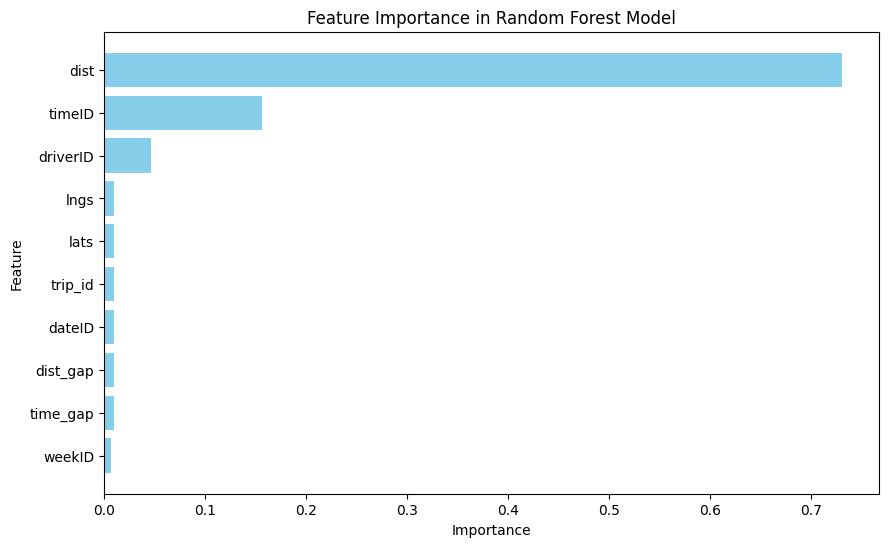

Feature  Importance
2      dist    0.730625
6    timeID    0.156357
4  driverID    0.046938
8      lngs    0.009847
3      lats    0.009845
0   trip_id    0.009828
7    dateID    0.009808
9  dist_gap    0.009763
1  time_gap    0.009714
5    weekID    0.007276

In [ ]:
feature_importances = model.feature_importances_

# Step 6: Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X_train_features.columns,
    'Importance': feature_importances
})

# Step 7: Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 8: Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

# Output the importance DataFrame for review
importance_df

### Step 6: Evaluate the Model with Learning Curves

In [ ]:
# Get current timestamp in Cairo time
cairo_tz = pytz.timezone('Africa/Cairo')
timestamp = datetime.now(cairo_tz).strftime('%Y-%m-%dT%H:%M:%S')

# Generate a unique label based on the timestamp
label = 'Model_Run_' + timestamp.replace(':', '').replace('-', '').split('.')[0]
# label = 'Model_Run_' + datetime.now().strftime("%Y%m%d_%H%M%S")

print(timestamp)
print(label)

2024-08-16T20:59:47
Model_Run_20240816T205947


In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(
    model, X_train.drop(columns=['trip_time']), y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5, scoring='neg_root_mean_squared_error')


fig = go.Figure()
fig.add_trace(go.Scatter(x=train_sizes, y=-np.mean(train_scores, axis=1), name='Training error'))
fig.add_trace(go.Scatter(x=train_sizes, y=-np.mean(valid_scores, axis=1), name='Validation error'))
fig.update_layout(
    title='Learning Curve: ' + label,
    xaxis_title='Number of Training Examples',
    yaxis_title='Root Mean Squared Error (RMSE)',
    legend_title='Error Type'
)
fig.show()

# Specify the directory and file name
output_directory = 'Careem_RFR_Figures/'  # Replace with your directory path
if not os.path.exists(output_directory):
    os.makedirs(output_directory)  # Create the directory if it doesn't exist
output_file = os.path.join(output_directory, f'learning_curve_v2.1_{label}.png')

# Save the figure
fig.write_image(output_file)

### Step 7: Make Predictions and Calculate Errors

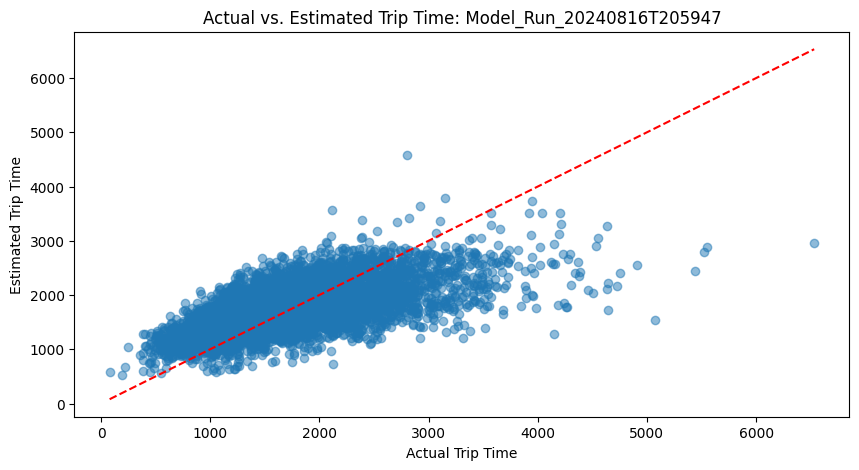

Mean Absolute Error (MAE): 390.49572726804627
R^2 Score: 0.4040463724914317


In [ ]:
def estimations(test_data, model, feature_names):
    features_data = test_data[feature_names]
    test_data['trip_time_estimate'] = model.predict(features_data)
    test_data['error'] = test_data['trip_time'] - test_data['trip_time_estimate']
    test_data = test_data.query("error < 3600")
    return test_data

# Get the feature names used during training
feature_names = X_train.drop(columns=['trip_time']).columns.tolist()

def plot_graphs(plot_df):
    plt.figure(figsize=(10, 5))
    plt.scatter(plot_df['trip_time'], plot_df['trip_time_estimate'], alpha=0.5)
    plt.plot([plot_df['trip_time'].min(), plot_df['trip_time'].max()], 
             [plot_df['trip_time'].min(), plot_df['trip_time'].max()], 'r--')
    plt.xlabel('Actual Trip Time')
    plt.ylabel('Estimated Trip Time')
    plt.title('Actual vs. Estimated Trip Time: ' + label)

    # Save the figure
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)  # Create the directory if it doesn't exist
    output_file = os.path.join(output_directory, f'actual_vs_estimated_v2.1_{label}.png')
    plt.savefig(output_file)
    plt.show()
    plt.close()

def get_metrics(plot_df):
    mae = mean_absolute_error(plot_df['trip_time'], plot_df['trip_time_estimate'])
    r2 = r2_score(plot_df['trip_time'], plot_df['trip_time_estimate'])
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R^2 Score: {r2}')
    return mae, r2

# Assuming plot_df is defined from the previous estimations step
plot_df = estimations(X_test, model, feature_names)
plot_graphs(plot_df)
mae, r2 = get_metrics(plot_df)

### Step 8: Log the results

In [ ]:
# Define the log file path
log_file_path = 'model_training_results_v2.1_log_.csv'

# Create a log file with headers if it doesn't exist
if not os.path.exists(log_file_path):
    with open(log_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Timestamp', 'Label', 'n_estimators', 'max_depth', 'min_samples_leaf', 'max_leaf_nodes', 'random_state', 'criterion', 'max_features', 'RMSE', 'MAE', 'R2_Score', 'Input_Data_Files', 'Contributor'])

def log_model_training(n_estimators, max_depth, min_samples_leaf, max_leaf_nodes, random_state, criterion, max_features, RMSE, MAE, R2_Score, input_data_files):
    # Log details into CSV file
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([timestamp, label, n_estimators, max_depth, min_samples_leaf, max_leaf_nodes, random_state, criterion, max_features, RMSE, MAE, R2_Score, input_data_files, contributor])


# Example usage
RMSE = rmse
MAE = mae
R2_Score = r2
# Convert list of files to a comma-separated string
input_data_files = ', '.join(files_names)
max_leaf_nodes = "Default"
criterion = "Default"
# input_data_files = 'clean_2024-01-25.json, clean_2024-01-26.json, clean_2024-01-27.json, clean_2024-01-28.json, clean_2024-01-29.json'

log_model_training(n_estimators, max_depth, min_samples_leaf, max_leaf_nodes, random_state, criterion, max_features, RMSE, MAE, R2_Score, input_data_files)


In [ ]:
from sklearn import tree
tree.plot_tree(model.estimators_[0])

[Text(0.5223511464497042, 0.9545454545454546, 'x[2] <= 7.22\nsquared_error = 475296.511\nsamples = 11772\nvalue = 1745.377'),
 Text(0.25737333579881655, 0.8636363636363636, 'x[2] <= 4.052\nsquared_error = 284669.619\nsamples = 6619\nvalue = 1443.2'),
 Text(0.3898622411242604, 0.9090909090909092, 'True  '),
 Text(0.11281897189349112, 0.7727272727272727, 'x[2] <= 2.21\nsquared_error = 222138.411\nsamples = 2863\nvalue = 1216.339'),
 Text(0.04571930473372781, 0.6818181818181818, 'x[2] <= 0.887\nsquared_error = 199776.172\nsamples = 912\nvalue = 1048.645'),
 Text(0.011926775147928994, 0.5909090909090909, 'x[4] <= 119.0\nsquared_error = 154802.722\nsamples = 125\nvalue = 797.264'),
 Text(0.004807692307692308, 0.5, 'x[5] <= 1.5\nsquared_error = 57997.652\nsamples = 11\nvalue = 526.812'),
 Text(0.0033284023668639054, 0.4090909090909091, 'squared_error = 27656.543\nsamples = 6\nvalue = 370.111'),
 Text(0.00628698224852071, 0.4090909090909091, 'squared_error = 24845.061\nsamples = 5\nvalue = 72

Error in callback <function _draw_all_if_interactive at 0x00000261B4E6B7E0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 